In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

from functions_file import *
print(testfunction(4))

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn as sn
import itertools
import collections        
from matplotlib import colors

from NNet import *
from scipy.stats import linregress
import copy
import time
from random import randrange

16


## Model-based Approach

### 1. Load Data

All columns:

    ['polygon','DOW','times','exp_id','lanes','direction',
    'busstops','seplane','complexity','length','road_rank',
    'v_Bus', 'k_Bus', 'q_Bus', # Taxi, Motorcycle, Heavy Vehicle, Medium Vehicle, Car
    'v_Car0020','k_Car0020', 'q_Car0020'] # e.g. 0020 = 2%

In [2]:
# speed_threshold = 1 #km/h
min_mean_speed = 15 #km/h
# min_diff_between_timestamps = '3s' #has to be a string
min_duration_of_stops = 5 #seconds

In [3]:
# Select desired data
cols = ['exp_id','times','polygon','DOW','lanes','busstops','seplane','length','road_rank','stop_count','lane_changes']
complexity = 1 # only use links with this level of complexity (exclude link 4)
modes_MS = ['Bus','Taxi','Car0050','Car','all','Motorcycle','Medium Vehicle']
modes_LD = ['all']
scalefactorsfile = '../output/data_processed/scalefactors_bypolygon.pkl'
datafile = '../output/data_processed_events_%skmh_%ssec/processed_data_all_bypolygon.pkl'%(min_mean_speed,min_duration_of_stops)

In [4]:
[cols.extend(['v_%s_MS'%(m),'q_%s_MS'%(m),'k_%s_MS'%(m)]) for m in modes_MS ]
[cols.extend(['v_%s_LD'%(m),'q_%s_LD'%(m),'k_%s_LD'%(m)]) for m in modes_LD ]
all_data = pd.read_pickle(datafile)
print(sorted(all_data.columns))
data = all_data[(all_data.complexity==complexity)][cols].reset_index(drop=True)

with open(scalefactorsfile, 'rb') as f:
    scalefactors = pickle.load(f)

data = data[~(data.polygon.isin(['polygon_r12','polygon_r13','polygon_r14','polygon_r15','polygon_r16',\
                      'polygon_r17','polygon_r18','polygon_r19','polygon_r20']))].reset_index(drop=True)

display(data.iloc[:3,:])

['DOW', 'busstops', 'complexity', 'density_induced', 'diff_1_all_MS', 'diff_2_all_MS', 'diff_3_all_MS', 'diff_to_threshold_quantile', 'direction', 'exp_id', 'k_Bus_MS', 'k_Car0050_MS', 'k_Car_MS', 'k_Heavy Vehicle_MS', 'k_Medium Vehicle_MS', 'k_Motorcycle_MS', 'k_Taxi_MS', 'k_all_LD', 'k_all_LD_s', 'k_all_MS', 'k_all_MS_s', 'lane_changes', 'lanes', 'length', 'polygon', 'q_Bus_MS', 'q_Car0050_MS', 'q_Car_MS', 'q_Heavy Vehicle_MS', 'q_Medium Vehicle_MS', 'q_Motorcycle_MS', 'q_Taxi_MS', 'q_all_LD', 'q_all_LD_s', 'q_all_MS', 'q_all_MS_s', 'road_rank', 'seplane', 'stop_count', 'threshold', 'times', 'v2', 'v_Bus_MS', 'v_Car0050_MS', 'v_Car_MS', 'v_Heavy Vehicle_MS', 'v_Medium Vehicle_MS', 'v_Motorcycle_MS', 'v_Taxi_MS', 'v_all_LD', 'v_all_MS', 'veh_stop_lengths', 'veh_stop_types']


exp_id               times     polygon  DOW  lanes  busstops  seplane  \
0     1.0 2018-10-24 08:31:00  polygon_r0  Wed      3         0        1   
1     1.0 2018-10-24 08:31:30  polygon_r0  Wed      3         0        1   
2     1.0 2018-10-24 08:32:00  polygon_r0  Wed      3         0        1   

   length  road_rank  stop_count  ...  k_all_MS  v_Motorcycle_MS  \
0   0.105          0         0.0  ...  1.554321        48.221745   
1   0.105          0         0.0  ...  1.479669        52.135825   
2   0.105          0         0.0  ...  1.044013        34.757217   

   q_Motorcycle_MS  k_Motorcycle_MS  v_Medium Vehicle_MS  q_Medium Vehicle_MS  \
0         0.821110         0.700837            46.890349             0.257684   
1         0.698574         0.561916            23.445175             0.128842   
2         0.465716         0.374610            32.578725             0.174600   

   k_Medium Vehicle_MS   v_all_LD  q_all_LD  k_all_LD  
0             0.226184  41.994024  2.037116  1.282766  
1             0.113092  46.472627  3.346691  1.849675  
2             0.147199  46.237944  2.570646  1.429280  

[3 rows x 35 columns]

## Multi-output NN with physical FD contraint (batched)

- CalcV --> calculate estimated derived speed and its error?
- Sensor scenarios --> can be found at the end of functions_file.py --> e.g. 'Scen1_qk'
- Input_sensor_cols --> e.g. ['q_all_LD','k_all_LD']

In [5]:
data['polygon'].index

RangeIndex(start=0, stop=4675, step=1)

##################################################################
0 Scen0_qk 0.6
##################################################################


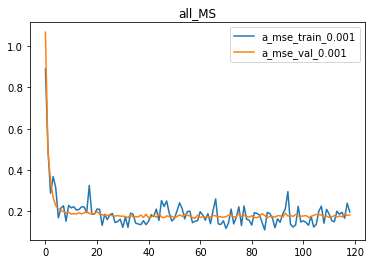

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [200.7135    14.598565]
Loss MAPE
 [0.15315147, 0.16070168]
Loss RMSE
 [384.78967   24.090069]
Loss R2
 [0.8210778664790787, 0.8161618314964938]
Loss MAE
 [200.71341, 14.598557]
Loss MAPE
 [1.8814935e+16, 428400700000000.0]
Loss RMSE
 [384.78975590574134, 24.09006512637458]
Loss R2
 [0.800312080803381, 0.8161205060918857]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


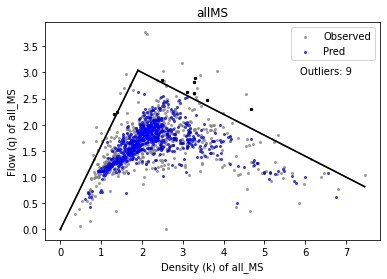

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.31726365 3.74094087]
Loss MAPE
 [0.5871178881490905, 0.4108325175009476]
Loss RMSE
 [2.68439856 5.2358133 ]
Loss R2
 [0.5104894507241574, 0.5620146857583779]
##################################################################
0 Scen1_qk 0.6
##################################################################


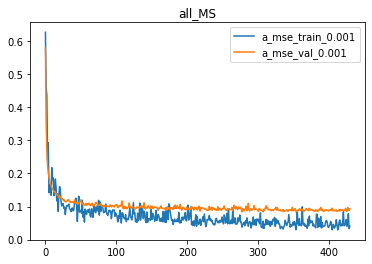

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [138.25404   12.675279]
Loss MAPE
 [0.11721264, 0.15495186]
Loss RMSE
 [269.83475   23.038445]
Loss R2
 [0.9075324763148781, 0.8544855566185886]
Loss MAE
 [138.25414, 12.675276]
Loss MAPE
 [90853465000000.0, 30105322000000.0]
Loss RMSE
 [269.8347439869447, 23.03844257812974]
Loss R2
 [0.9068383371785336, 0.854429546327161]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


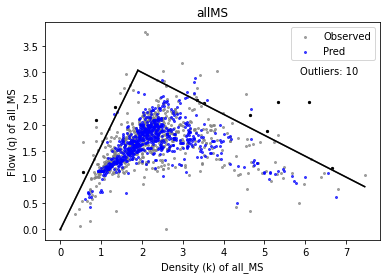

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.0862859  3.92213489]
Loss MAPE
 [0.5165607885542516, 0.421340331898338]
Loss RMSE
 [1.77689127 5.11315522]
Loss R2
 [0.6964015465254915, 0.6088380331510008]
##################################################################
0 Scen3_qk 0.6
##################################################################


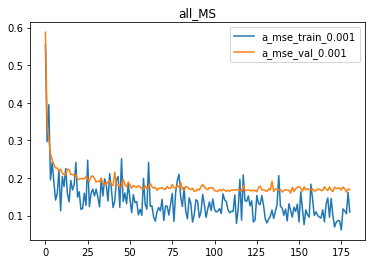

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [206.55522   14.188039]
Loss MAPE
 [0.11273856, 0.14027384]
Loss RMSE
 [361.0839    23.259115]
Loss R2
 [0.8322018189232262, 0.8402697717820181]
Loss MAE
 [206.5552, 14.188022]
Loss MAPE
 [3.7873382e+16, 1135105000000000.0]
Loss RMSE
 [361.08391510838584, 23.259110173321066]
Loss R2
 [0.8248656780149585, 0.8392784991138387]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


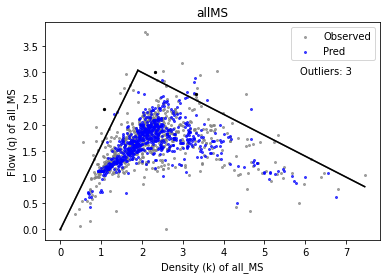

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.60816502 3.79005753]
Loss MAPE
 [0.5158612507748342, 0.42040652171171494]
Loss RMSE
 [2.36242501 5.17314868]
Loss R2
 [0.6580710463954157, 0.6086105949334083]
##################################################################
0 Scen10_qk 0.6
##################################################################


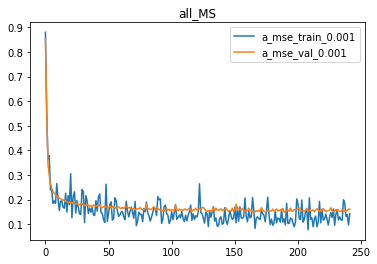

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [173.61327   15.807742]
Loss MAPE
 [0.13626105, 0.18533354]
Loss RMSE
 [317.4335    28.885483]
Loss R2
 [0.8723821578700729, 0.7915320228933567]
Loss MAE
 [173.61322, 15.807754]
Loss MAPE
 [3318362000000000.0, 100508620000000.0]
Loss RMSE
 [317.433506816782, 28.88548557416802]
Loss R2
 [0.8710720608096287, 0.7711629796524635]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


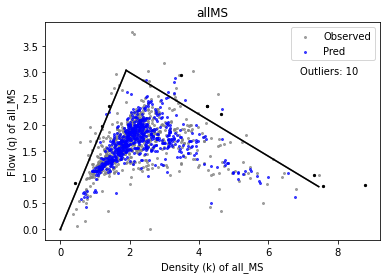

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.19337712 3.73533971]
Loss MAPE
 [0.5385925778933706, 0.3416610756220809]
Loss RMSE
 [2.25262553 5.22452137]
Loss R2
 [0.6316589514627214, 0.60287675797527]
##################################################################
0 Scen11_qk 0.6
##################################################################


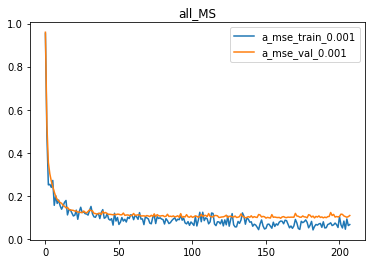

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 18
Loss MAE
 [144.91405   12.239468]
Loss MAPE
 [0.14521462, 0.1506525]
Loss RMSE
 [274.03198   18.466707]
Loss R2
 [0.9042130029870925, 0.9107176405884693]
Loss MAE
 [144.91405, 12.239464]
Loss MAPE
 [0.14521462, 0.1506525]
Loss RMSE
 [274.0319609552871, 18.466709185573137]
Loss R2
 [0.9022702357286358, 0.8901723880873602]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


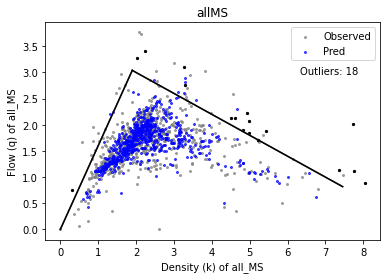

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.29486624 3.81455832]
Loss MAPE
 [0.35471070290595846, 0.3491131163299844]
Loss RMSE
 [1.80780872 5.39225452]
Loss R2
 [0.7855372336210729, 0.5794422056501661]
##################################################################
1 Scen0_qk 0.6
##################################################################


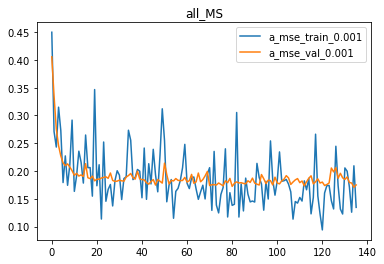

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [194.11691   15.619422]
Loss MAPE
 [0.16569886, 0.17794687]
Loss RMSE
 [365.30917  26.28483]
Loss R2
 [0.8396082802678004, 0.8030545596077712]
Loss MAE
 [194.1169, 15.6194105]
Loss MAPE
 [2.2180392e+16, 576669500000000.0]
Loss RMSE
 [365.3092439974658, 26.284834355381502]
Loss R2
 [0.8317235212976394, 0.7953404939764136]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


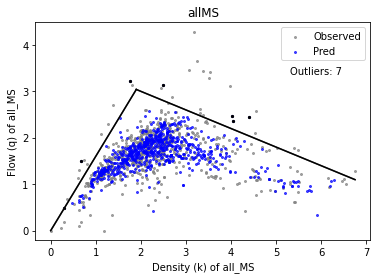

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.25600524 3.96897325]
Loss MAPE
 [0.5816783008547283, 0.3787302064697248]
Loss RMSE
 [2.25105989 5.63335772]
Loss R2
 [0.6372461879030223, 0.5622767402008212]
##################################################################
1 Scen1_qk 0.6
##################################################################


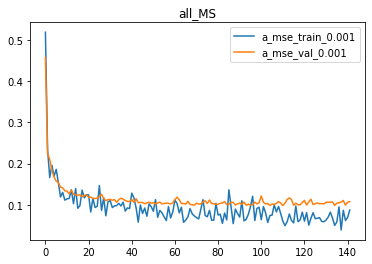

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 19
Loss MAE
 [151.85938  12.17976]
Loss MAPE
 [0.14410861, 0.14831197]
Loss RMSE
 [258.59998   17.580208]
Loss R2
 [0.9186635876543605, 0.9156310661528216]
Loss MAE
 [151.85951, 12.179761]
Loss MAPE
 [0.14410861, 0.14831197]
Loss RMSE
 [258.59986586423435, 17.580207341938458]
Loss R2
 [0.9129675878518391, 0.9004639142963412]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


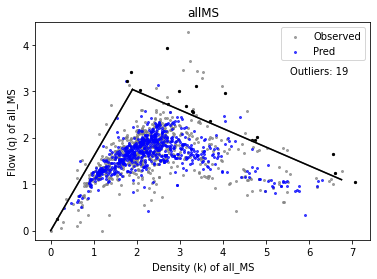

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.10547158 4.23423688]
Loss MAPE
 [0.4407836756140786, 0.339795606152269]
Loss RMSE
 [1.93707598 6.04070466]
Loss R2
 [0.7390787981263729, 0.5571740322084787]
##################################################################
1 Scen3_qk 0.6
##################################################################


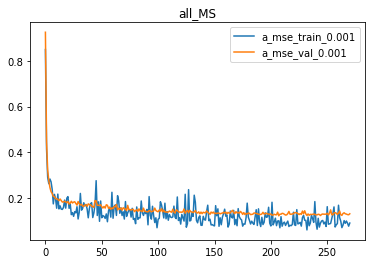

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 16
Loss MAE
 [186.56267   14.163252]
Loss MAPE
 [0.14395694, 0.17110279]
Loss RMSE
 [336.33386  25.5052 ]
Loss R2
 [0.8718390937663884, 0.8258296180132021]
Loss MAE
 [186.56268, 14.163264]
Loss MAPE
 [5654026500000000.0, 200173300000000.0]
Loss RMSE
 [336.33394630560264, 25.505191050211966]
Loss R2
 [0.8552619084161094, 0.821587978239614]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


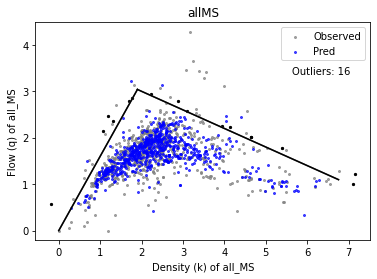

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.29540604 3.90773091]
Loss MAPE
 [0.49272996998271096, 0.4051912523859141]
Loss RMSE
 [2.00099674 5.36984027]
Loss R2
 [0.6991292361755632, 0.5837397803453408]
##################################################################
1 Scen10_qk 0.6
##################################################################


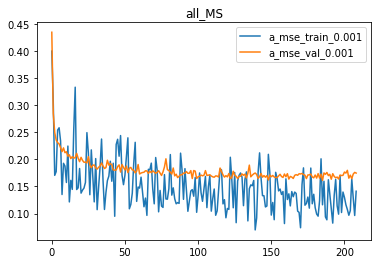

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [162.62952   15.676318]
Loss MAPE
 [0.10914645, 0.16008176]
Loss RMSE
 [281.62735  25.90171]
Loss R2
 [0.8946156716651064, 0.8164966562497548]
Loss MAE
 [162.62947, 15.676315]
Loss MAPE
 [8244943500000000.0, 304269480000000.0]
Loss RMSE
 [281.6273440870045, 25.901706053170393]
Loss R2
 [0.891782329984521, 0.8132634481485457]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


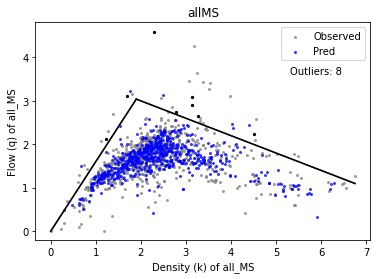

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.20779504 3.71433138]
Loss MAPE
 [0.5246882409098389, 0.34506243377699264]
Loss RMSE
 [2.27174379 5.18818917]
Loss R2
 [0.6316231662528595, 0.605247402382206]
##################################################################
1 Scen11_qk 0.6
##################################################################


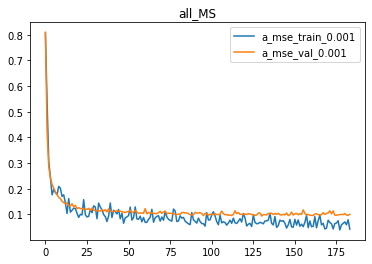

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [155.93211   10.961245]
Loss MAPE
 [0.10105032, 0.11794054]
Loss RMSE
 [278.834     17.524643]
Loss R2
 [0.8994151363675242, 0.9131688371214527]
Loss MAE
 [155.93214, 10.961249]
Loss MAPE
 [1.1830865e+16, 380180700000000.0]
Loss RMSE
 [278.83409605892894, 17.52464085536063]
Loss R2
 [0.898298095132452, 0.9094320750691882]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


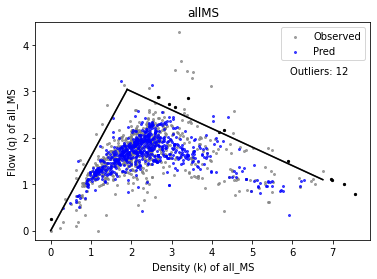

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.17532304 4.06303912]
Loss MAPE
 [0.40823296271347037, 0.47677973392653217]
Loss RMSE
 [1.75690303 5.72678525]
Loss R2
 [0.7872110196244032, 0.5839630146946011]
##################################################################
2 Scen0_qk 0.6
##################################################################


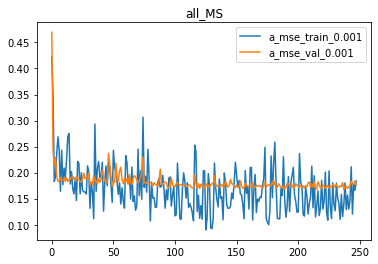

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [187.73337    14.0974655]
Loss MAPE
 [0.1367161, 0.14337182]
Loss RMSE
 [348.863     23.844177]
Loss R2
 [0.8464725936799767, 0.8246735704498622]
Loss MAE
 [187.73335, 14.097463]
Loss MAPE
 [1.9178575e+16, 427632000000000.0]
Loss RMSE
 [348.86304171551336, 23.8441877212443]
Loss R2
 [0.8358598869141239, 0.819854897133897]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


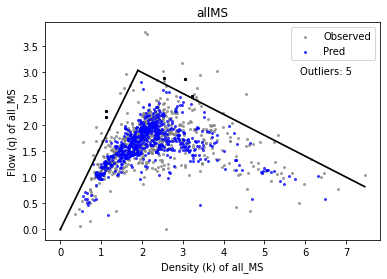

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.41978349 3.99919526]
Loss MAPE
 [0.5777537391277386, 0.45160762282910416]
Loss RMSE
 [2.22349524 5.59396049]
Loss R2
 [0.6266582299036552, 0.5485754159244022]
##################################################################
2 Scen1_qk 0.6
##################################################################


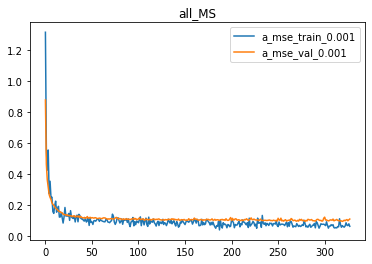

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [148.00197   11.204848]
Loss MAPE
 [0.09508933, 0.11449882]
Loss RMSE
 [257.23047   17.823687]
Loss R2
 [0.9143577221280015, 0.9095127077434986]
Loss MAE
 [148.00194, 11.204852]
Loss MAPE
 [9323693000000000.0, 306157180000000.0]
Loss RMSE
 [257.23057810551995, 17.823687550297358]
Loss R2
 [0.9134469385844861, 0.9063147475962021]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


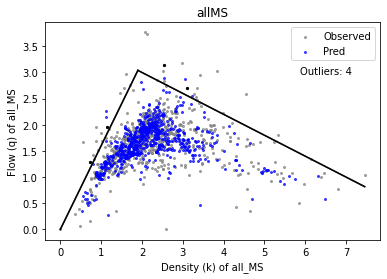

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [0.98263125 4.02017795]
Loss MAPE
 [0.5050378521245459, 0.4341035712671521]
Loss RMSE
 [1.79885044 5.28634049]
Loss R2
 [0.7009201568023363, 0.5870215422563255]
##################################################################
2 Scen3_qk 0.6
##################################################################


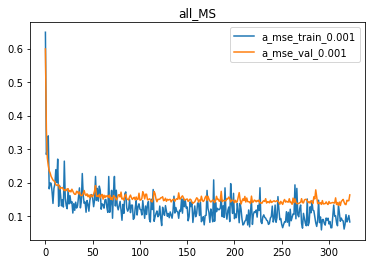

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [170.45927   15.506157]
Loss MAPE
 [0.13592403, 0.1760997]
Loss RMSE
 [316.47858  26.67848]
Loss R2
 [0.876296819752037, 0.8410275006959644]
Loss MAE
 [170.45932, 15.506164]
Loss MAPE
 [1237375500000000.0, 54395950000000.0]
Loss RMSE
 [316.4785735243383, 26.67846927123537]
Loss R2
 [0.871846594552508, 0.8047959548758108]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


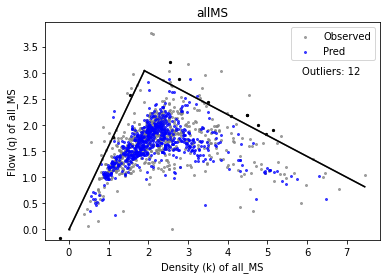

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.27720932 4.11409916]
Loss MAPE
 [0.6151588377164187, 0.4683936987522981]
Loss RMSE
 [2.23715683 5.80510716]
Loss R2
 [0.6721536623295581, 0.544923045849481]
##################################################################
2 Scen10_qk 0.6
##################################################################


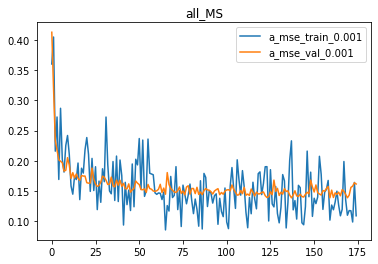

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [164.52864   16.586985]
Loss MAPE
 [0.097365506, 0.19345789]
Loss RMSE
 [279.65607   29.560034]
Loss R2
 [0.8945013210590774, 0.7908114378276189]
Loss MAE
 [164.52872, 16.586983]
Loss MAPE
 [2735389200000000.0, 0.19345789]
Loss RMSE
 [279.6560806374501, 29.56003474789695]
Loss R2
 [0.8892054715669594, 0.7358790907017433]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


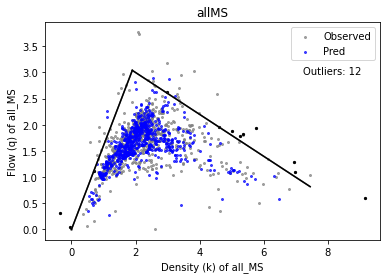

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.17947057 3.79613916]
Loss MAPE
 [0.5691528380778142, 0.35037442039404104]
Loss RMSE
 [2.29316066 5.3249984 ]
Loss R2
 [0.6323108634377075, 0.5901141533950788]
##################################################################
2 Scen11_qk 0.6
##################################################################


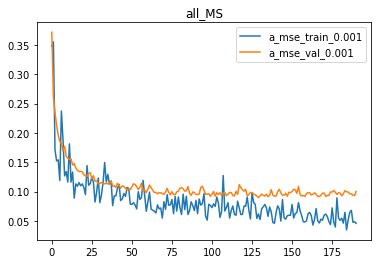

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [138.04167   11.907882]
Loss MAPE
 [0.0945145, 0.124964304]
Loss RMSE
 [233.04341  20.3661 ]
Loss R2
 [0.9280242583335632, 0.8859238397996575]
Loss MAE
 [138.04161, 11.907872]
Loss MAPE
 [4296095000000000.0, 121701310000000.0]
Loss RMSE
 [233.04344250321657, 20.366098156042618]
Loss R2
 [0.9258992956774441, 0.8845515186556554]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


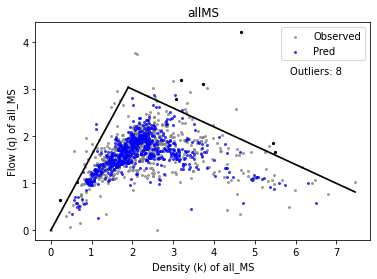

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.16502515 3.81515961]
Loss MAPE
 [0.49088281166143954, 0.3767753617737673]
Loss RMSE
 [2.01212987 5.52045759]
Loss R2
 [0.7574838405259648, 0.5745076148662634]
##################################################################
3 Scen0_qk 0.6
##################################################################


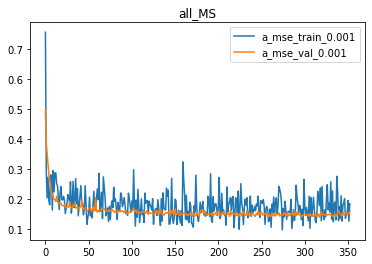

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [184.79002   15.120251]
Loss MAPE
 [0.1086751, 0.16666085]
Loss RMSE
 [321.52994   27.098423]
Loss R2
 [0.8767050597945129, 0.7822748718393641]
Loss MAE
 [184.78998, 15.120245]
Loss MAPE
 [6387789400000000.0, 0.16666085]
Loss RMSE
 [321.5299606957336, 27.098418400068226]
Loss R2
 [0.8535421484064727, 0.7780369110064045]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


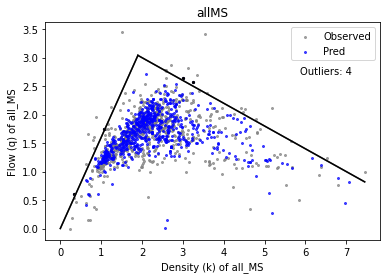

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.23707332 4.26958648]
Loss MAPE
 [0.6177565617376645, 0.429162953922995]
Loss RMSE
 [2.2346957  5.62938464]
Loss R2
 [0.5332686869937703, 0.5554682478672237]
##################################################################
3 Scen1_qk 0.6
##################################################################


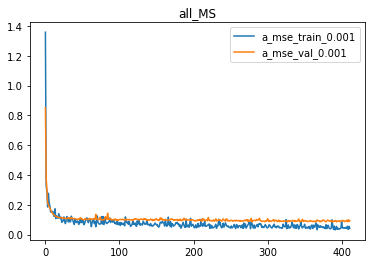

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 15
Loss MAE
 [134.10466   11.407723]
Loss MAPE
 [0.11580108, 0.14721936]
Loss RMSE
 [262.63242   19.483782]
Loss R2
 [0.9134862994162659, 0.8968204553405775]
Loss MAE
 [134.1047, 11.407719]
Loss MAPE
 [1371946500000000.0, 51116767000000.0]
Loss RMSE
 [262.632407082599, 19.48378059563462]
Loss R2
 [0.9117452552292357, 0.8958849743323435]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


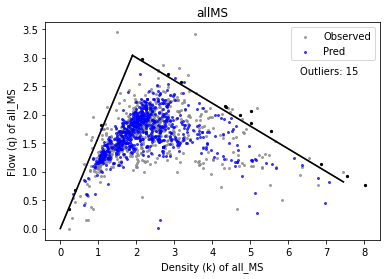

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.01621955 3.98973488]
Loss MAPE
 [0.5344888272800371, 0.45349674211109925]
Loss RMSE
 [1.82317855 5.37708403]
Loss R2
 [0.6824883905538214, 0.5756083367812388]
##################################################################
3 Scen3_qk 0.6
##################################################################


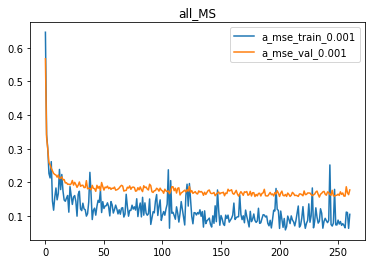

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [223.52925   14.646861]
Loss MAPE
 [0.17550555, 0.1711153]
Loss RMSE
 [381.8194    26.535244]
Loss R2
 [0.8433258235213618, 0.7939160707596163]
Loss MAE
 [223.52925, 14.64686]
Loss MAPE
 [405544300000000.0, 0.1711153]
Loss RMSE
 [381.81930854135703, 26.53524106833566]
Loss R2
 [0.8095385636685942, 0.7886535944524631]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


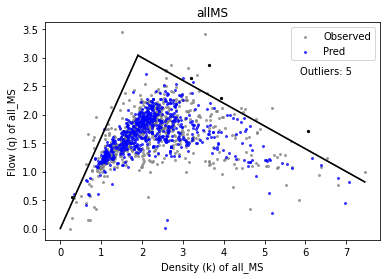

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.48619595 4.40606613]
Loss MAPE
 [0.5615116733019069, 0.49604649425512826]
Loss RMSE
 [2.24554354 5.96378246]
Loss R2
 [0.6313186558367209, 0.517339576447316]
##################################################################
3 Scen10_qk 0.6
##################################################################


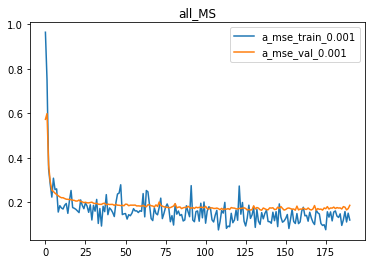

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [176.53464   14.988499]
Loss MAPE
 [0.11592688, 0.14553504]
Loss RMSE
 [292.55405   26.417156]
Loss R2
 [0.8886407068020539, 0.8097806703323367]
Loss MAE
 [176.5347, 14.988493]
Loss MAPE
 [7386306000000000.0, 247988910000000.0]
Loss RMSE
 [292.55400142537786, 26.417159820991593]
Loss R2
 [0.8832221039464627, 0.805757247920041]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


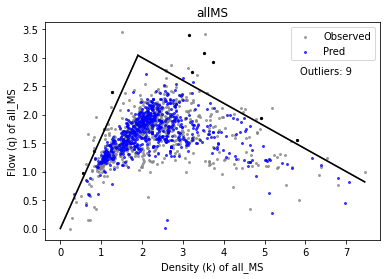

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.20333897 3.76249909]
Loss MAPE
 [0.5773116572690377, 0.37629255865675215]
Loss RMSE
 [2.18931465 5.28988713]
Loss R2
 [0.6448944047014651, 0.6188649531433114]
##################################################################
3 Scen11_qk 0.6
##################################################################


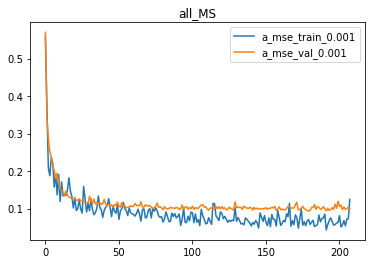

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [167.10777   12.052625]
Loss MAPE
 [0.13304831, 0.14391744]
Loss RMSE
 [293.9572    20.985846]
Loss R2
 [0.8987694633459916, 0.8832001894788021]
Loss MAE
 [167.1078, 12.052623]
Loss MAPE
 [3322982000000000.0, 127160140000000.0]
Loss RMSE
 [293.9572407255858, 20.98584670006788]
Loss R2
 [0.8894370081442606, 0.8792130625249781]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


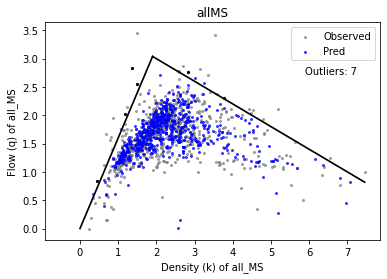

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.52123702 4.23014852]
Loss MAPE
 [0.4118439914773038, 0.554173926590301]
Loss RMSE
 [2.28084231 5.64399528]
Loss R2
 [0.6713205328114284, 0.5171593032568044]
##################################################################
4 Scen0_qk 0.6
##################################################################


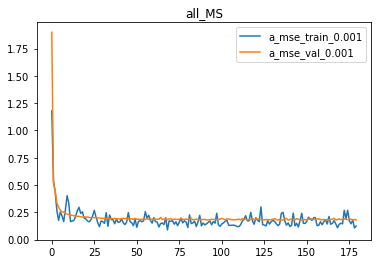

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [184.65529   16.250065]
Loss MAPE
 [0.14379925, 0.19799905]
Loss RMSE
 [356.9663   28.81575]
Loss R2
 [0.8475399214534043, 0.7727106556633906]
Loss MAE
 [184.65524, 16.250061]
Loss MAPE
 [5919696500000000.0, 147307680000000.0]
Loss RMSE
 [356.96637402912336, 28.815747258036925]
Loss R2
 [0.8369592705891298, 0.7722665831659377]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


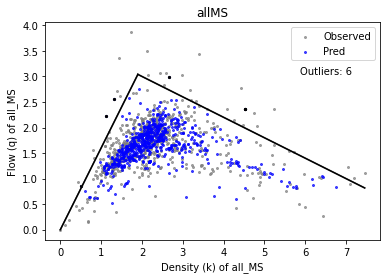

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.32555868 3.81652377]
Loss MAPE
 [0.578996119081733, 0.38185245540510987]
Loss RMSE
 [2.33044547 5.31627094]
Loss R2
 [0.6054747603564397, 0.6106916575159694]
##################################################################
4 Scen1_qk 0.6
##################################################################


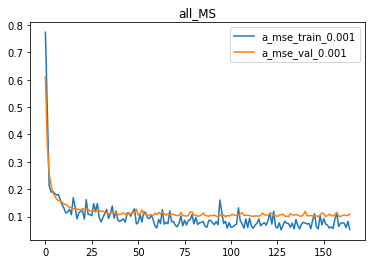

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 21
Loss MAE
 [132.72093   12.901415]
Loss MAPE
 [0.14162408, 0.15515383]
Loss RMSE
 [254.1487   18.57094]
Loss R2
 [0.9172026816593774, 0.9101898929120517]
Loss MAE
 [132.72095, 12.901415]
Loss MAPE
 [0.14162408, 0.15515383]
Loss RMSE
 [254.1486554410627, 18.570944358465844]
Loss R2
 [0.9159379310499081, 0.8889290424314341]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


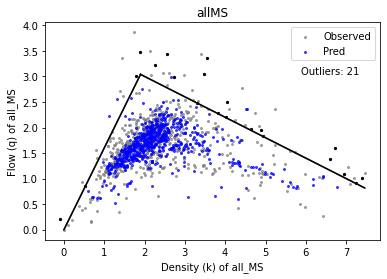

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.15883131 3.96706979]
Loss MAPE
 [0.43179705982884586, 0.49846652212089526]
Loss RMSE
 [2.25299993 5.77399996]
Loss R2
 [0.6081759000647775, 0.5199357971145644]
##################################################################
4 Scen3_qk 0.6
##################################################################


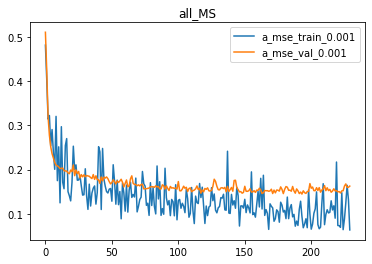

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [191.65848   14.559847]
Loss MAPE
 [0.12803692, 0.1438289]
Loss RMSE
 [348.8915    25.240389]
Loss R2
 [0.8508705541856737, 0.8217839775327277]
Loss MAE
 [191.65837, 14.559846]
Loss MAPE
 [1.5323347e+16, 544166720000000.0]
Loss RMSE
 [348.8914139814851, 25.240381202781364]
Loss R2
 [0.8407725764666474, 0.8121254555144334]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


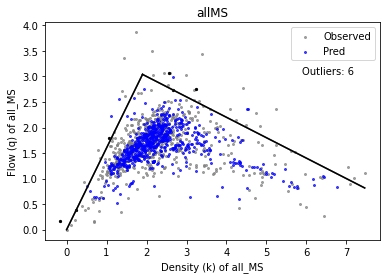

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.2475499  3.93378359]
Loss MAPE
 [0.5515632857887298, 0.4301608874435605]
Loss RMSE
 [1.99824857 5.36267043]
Loss R2
 [0.7159073046484153, 0.5964168730960383]
##################################################################
4 Scen10_qk 0.6
##################################################################


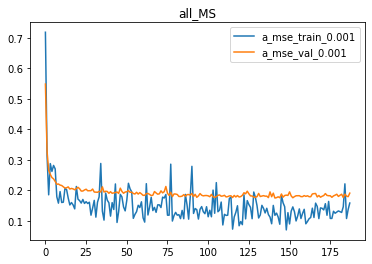

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [234.67703   15.210687]
Loss MAPE
 [0.12851776, 0.14661191]
Loss RMSE
 [388.1127    25.258888]
Loss R2
 [0.8160415466737619, 0.8171902792514079]
Loss MAE
 [234.67691, 15.21069]
Loss MAPE
 [3.4479246e+16, 1119990640000000.0]
Loss RMSE
 [388.112680963918, 25.258885397101476]
Loss R2
 [0.7976651684272485, 0.810453346652684]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


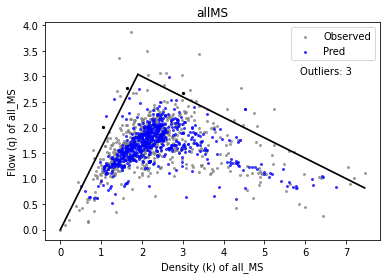

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.14441749 3.82907041]
Loss MAPE
 [0.5728245968168649, 0.37035336081040593]
Loss RMSE
 [2.1302243  5.38119177]
Loss R2
 [0.6393102800931304, 0.5907710910692391]
##################################################################
4 Scen11_qk 0.6
##################################################################


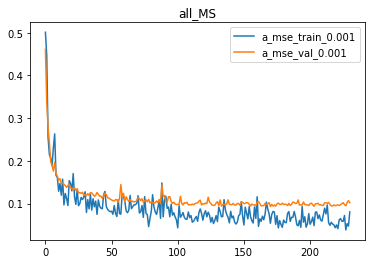

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 17
Loss MAE
 [139.59624   12.422822]
Loss MAPE
 [0.14392057, 0.14340365]
Loss RMSE
 [261.9394   17.98169]
Loss R2
 [0.910946789274377, 0.9067996379785772]
Loss MAE
 [139.59619, 12.422824]
Loss MAPE
 [0.14392057, 0.14340365]
Loss RMSE
 [261.9393566505423, 17.981682676135577]
Loss R2
 [0.9107052433513406, 0.8958658351434039]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


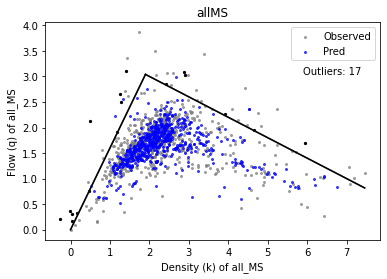

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.1972856  3.91010155]
Loss MAPE
 [0.5506072876810126, 0.3510597502277989]
Loss RMSE
 [2.08921083 5.61759328]
Loss R2
 [0.699656041213784, 0.5641285836842298]
##################################################################
5 Scen0_qk 0.6
##################################################################


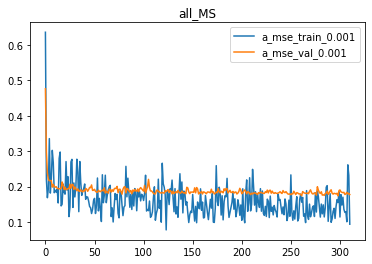

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [179.7063    15.785728]
Loss MAPE
 [0.13421825, 0.18801095]
Loss RMSE
 [330.4562    29.837473]
Loss R2
 [0.8633868543044969, 0.7611680338816169]
Loss MAE
 [179.70615, 15.785724]
Loss MAPE
 [3815318800000000.0, 119741260000000.0]
Loss RMSE
 [330.4561950924812, 29.837476843963575]
Loss R2
 [0.8602765599450741, 0.7558306466552382]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


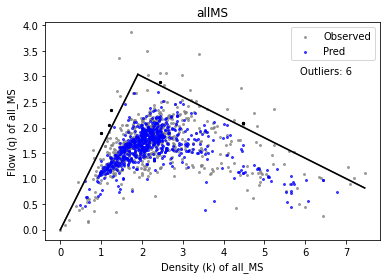

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.18031921 4.06380042]
Loss MAPE
 [0.6039824617483198, 0.43308000018809895]
Loss RMSE
 [2.19734014 5.32975968]
Loss R2
 [0.5349418625749303, 0.5752621274705934]
##################################################################
5 Scen1_qk 0.6
##################################################################


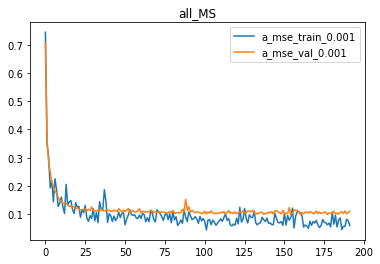

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [153.24973    12.1177635]
Loss MAPE
 [0.099531144, 0.124671035]
Loss RMSE
 [274.76242   18.234764]
Loss R2
 [0.9017509045416886, 0.9115530958266512]
Loss MAE
 [153.24968, 12.1177635]
Loss MAPE
 [1.3783952e+16, 482851930000000.0]
Loss RMSE
 [274.7623547040242, 18.234762440988828]
Loss R2
 [0.9012466764824701, 0.9019435077127205]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


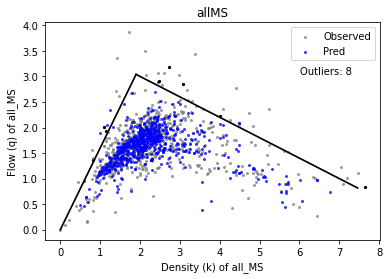

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.27145519 3.80330796]
Loss MAPE
 [0.43565328780525053, 0.41904226479901924]
Loss RMSE
 [2.10235094 5.44318968]
Loss R2
 [0.7106954211948853, 0.5845916611077951]
##################################################################
5 Scen3_qk 0.6
##################################################################


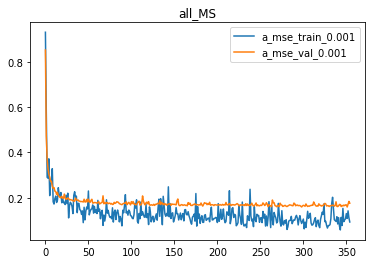

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [191.05028   15.552901]
Loss MAPE
 [0.11119822, 0.16793653]
Loss RMSE
 [346.12738  23.51332]
Loss R2
 [0.8470261688945558, 0.8573353875568429]
Loss MAE
 [191.05022, 15.552901]
Loss MAPE
 [3.6867875e+16, 1133552200000000.0]
Loss RMSE
 [346.1274038378065, 23.513325261301304]
Loss R2
 [0.8390737197175903, 0.8357460400607792]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


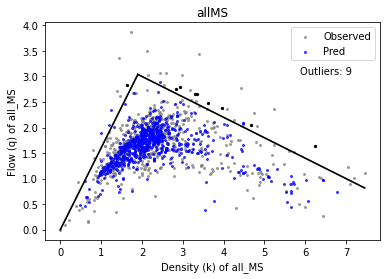

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.27198907 3.92886157]
Loss MAPE
 [0.6069096777590866, 0.3878291967287785]
Loss RMSE
 [2.7949729  5.74361125]
Loss R2
 [0.5815368504239974, 0.6181299279845681]
##################################################################
5 Scen10_qk 0.6
##################################################################


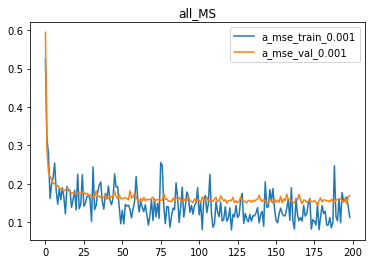

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [179.4109    17.717093]
Loss MAPE
 [0.1341519, 0.20415542]
Loss RMSE
 [330.23254   31.444473]
Loss R2
 [0.8656972705289734, 0.7709169804526907]
Loss MAE
 [179.41096, 17.717104]
Loss MAPE
 [5911207000000000.0, 304993480000000.0]
Loss RMSE
 [330.23263580391324, 31.444474950026]
Loss R2
 [0.8604655422966971, 0.7288212855969728]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


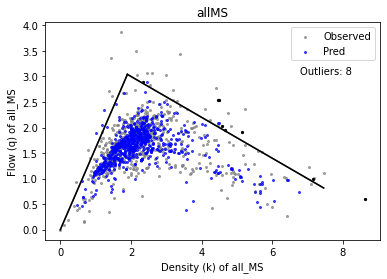

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.17856495 3.82877219]
Loss MAPE
 [0.5422448015633108, 0.38448812017713296]
Loss RMSE
 [2.29635401 5.34943587]
Loss R2
 [0.6184658318248328, 0.5920482086476297]
##################################################################
5 Scen11_qk 0.6
##################################################################


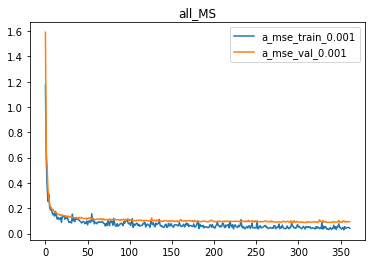

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [135.92924   11.076354]
Loss MAPE
 [0.09713193, 0.13942802]
Loss RMSE
 [236.82765   18.475725]
Loss R2
 [0.9239515606132938, 0.9067355779158792]
Loss MAE
 [135.9292, 11.076348]
Loss MAPE
 [5935851500000000.0, 0.13942802]
Loss RMSE
 [236.82770800995817, 18.475729202932104]
Loss R2
 [0.9205425269039812, 0.8968198739274917]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


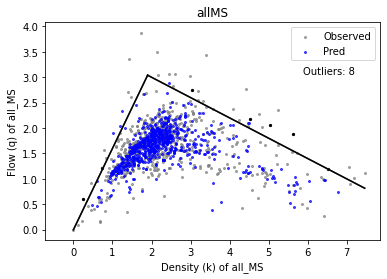

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.16336457 4.22257456]
Loss MAPE
 [0.5014402704524892, 0.4477566099127033]
Loss RMSE
 [1.96370381 8.82952436]
Loss R2
 [0.7264715744667108, 0.2829491078082651]
##################################################################
6 Scen0_qk 0.6
##################################################################


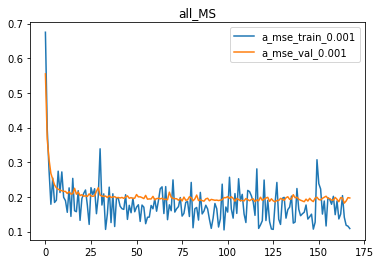

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [174.85481  16.77892]
Loss MAPE
 [0.11290496, 0.17107071]
Loss RMSE
 [322.21045  28.66518]
Loss R2
 [0.8677742851970957, 0.785186251570655]
Loss MAE
 [174.8548, 16.778921]
Loss MAPE
 [8331843000000000.0, 348808720000000.0]
Loss RMSE
 [322.2104926325336, 28.665180374767726]
Loss R2
 [0.8583463108187297, 0.7712916728808683]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


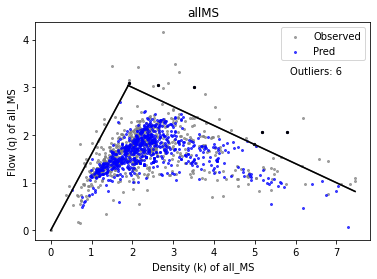

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.50646386 3.95760529]
Loss MAPE
 [0.5482001869562881, 0.44913689036181775]
Loss RMSE
 [2.42164341 6.13606522]
Loss R2
 [0.5890444790369369, 0.5145618909327727]
##################################################################
6 Scen1_qk 0.6
##################################################################


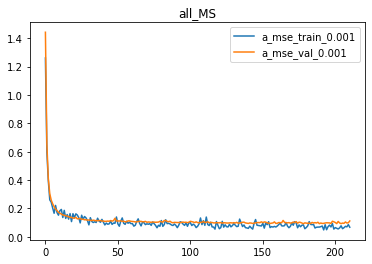

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [150.04782   13.069451]
Loss MAPE
 [0.13116539, 0.17425708]
Loss RMSE
 [278.54315   22.701435]
Loss R2
 [0.9067339087695387, 0.86073918004988]
Loss MAE
 [150.04782, 13.069446]
Loss MAPE
 [5337045000000000.0, 144178240000000.0]
Loss RMSE
 [278.54312671020983, 22.701439308547982]
Loss R2
 [0.9007280890398368, 0.8586571734440882]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


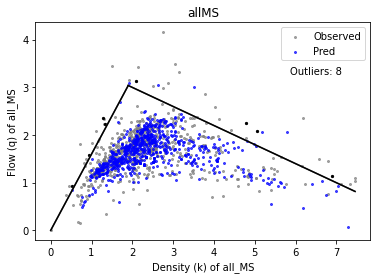

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.03196813 3.97540284]
Loss MAPE
 [0.4575530795206499, 0.40325448353438936]
Loss RMSE
 [1.81206766 5.75008306]
Loss R2
 [0.8276126308824749, 0.6064788864586347]
##################################################################
6 Scen3_qk 0.6
##################################################################


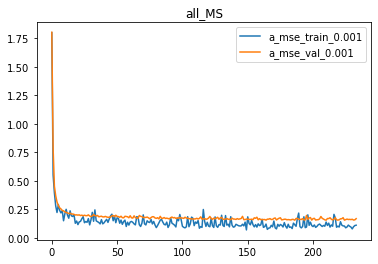

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [197.59505   15.157153]
Loss MAPE
 [0.15811837, 0.18398601]
Loss RMSE
 [364.91727   27.275707]
Loss R2
 [0.8374462844292223, 0.7888269070884664]
Loss MAE
 [197.59502, 15.1571665]
Loss MAPE
 [1768877900000000.0, 0.18398601]
Loss RMSE
 [364.9173279662121, 27.275714465607955]
Loss R2
 [0.8260276451928258, 0.7766936268866341]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


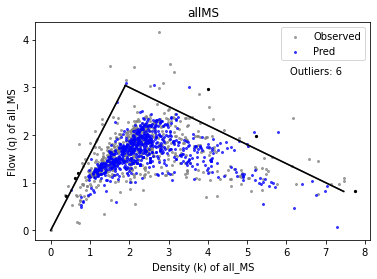

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.09252052 3.93480187]
Loss MAPE
 [0.5496165170918544, 0.37379569949817687]
Loss RMSE
 [1.97201651 5.50560158]
Loss R2
 [0.71305378620594, 0.5773100782063864]
##################################################################
6 Scen10_qk 0.6
##################################################################


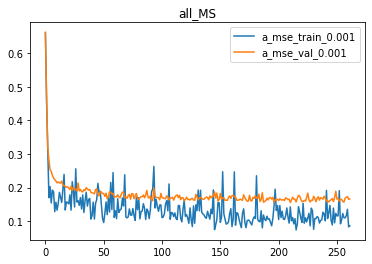

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [213.47966   15.782441]
Loss MAPE
 [0.16303937, 0.19424151]
Loss RMSE
 [353.78394   28.100958]
Loss R2
 [0.84925749266675, 0.7721233889797411]
Loss MAE
 [213.47961, 15.782444]
Loss MAPE
 [1631993800000000.0, 0.19424151]
Loss RMSE
 [353.7839758418971, 28.100964121722097]
Loss R2
 [0.8364812461087181, 0.7629765804009901]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


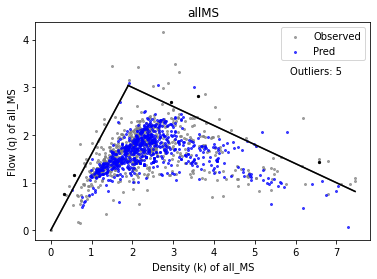

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.24351387 3.69577844]
Loss MAPE
 [0.5247082636140887, 0.41760007278255973]
Loss RMSE
 [2.24500901 5.10422381]
Loss R2
 [0.6445505783930638, 0.6091409797669893]
##################################################################
6 Scen11_qk 0.6
##################################################################


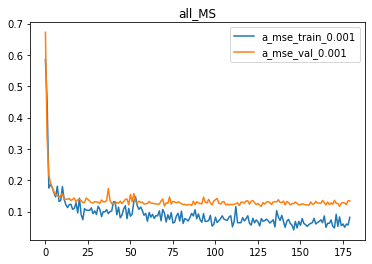

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [155.83873   10.712638]
Loss MAPE
 [0.12236673, 0.12228899]
Loss RMSE
 [255.4607    18.271557]
Loss R2
 [0.919756829790231, 0.8984464829551247]
Loss MAE
 [155.8386, 10.71264]
Loss MAPE
 [1.1339622e+16, 121358490000000.0]
Loss RMSE
 [255.4606134025361, 18.271554420128968]
Loss R2
 [0.9119858059281686, 0.8942188223845794]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


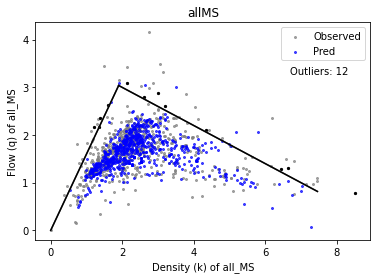

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.30392517 3.98636495]
Loss MAPE
 [0.45318938930058683, 0.4535714566252681]
Loss RMSE
 [1.9530474  5.72066789]
Loss R2
 [0.8141069584382595, 0.6178943110802357]
##################################################################
7 Scen0_qk 0.6
##################################################################


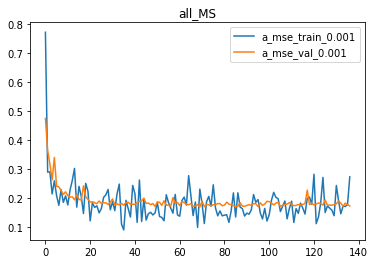

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [195.06653   14.509477]
Loss MAPE
 [0.13876024, 0.15718271]
Loss RMSE
 [364.94305   23.700544]
Loss R2
 [0.8336138912774251, 0.8223199631840593]
Loss MAE
 [195.06648, 14.50948]
Loss MAPE
 [1.8707905e+16, 437235150000000.0]
Loss RMSE
 [364.943060627271, 23.700546013703065]
Loss R2
 [0.8203798754116247, 0.8220188386081823]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


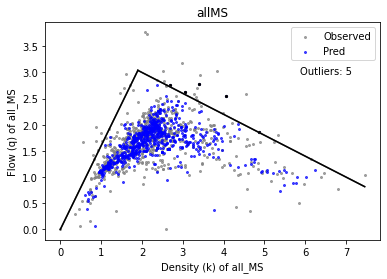

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.19504053 3.65193396]
Loss MAPE
 [0.5903616457556633, 0.38542737825659323]
Loss RMSE
 [2.19766695 4.90123824]
Loss R2
 [0.6157188914887004, 0.6180446346465749]
##################################################################
7 Scen1_qk 0.6
##################################################################


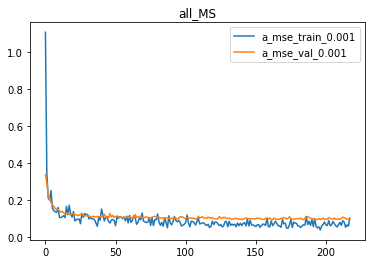

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [135.17732   11.025562]
Loss MAPE
 [0.1392571, 0.12979372]
Loss RMSE
 [246.0854    16.875961]
Loss R2
 [0.9220575396185565, 0.9110443125509027]
Loss MAE
 [135.17728, 11.025561]
Loss MAPE
 [0.1392571, 0.12979372]
Loss RMSE
 [246.0853589839306, 16.875963875828877]
Loss R2
 [0.9211873399693805, 0.9082788142604844]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


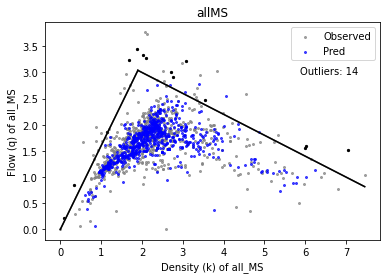

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.01889178 3.72313146]
Loss MAPE
 [0.4461690395110559, 0.44577132900851535]
Loss RMSE
 [1.90320092 5.2306807 ]
Loss R2
 [0.7429834300704372, 0.6053080618816818]
##################################################################
7 Scen3_qk 0.6
##################################################################


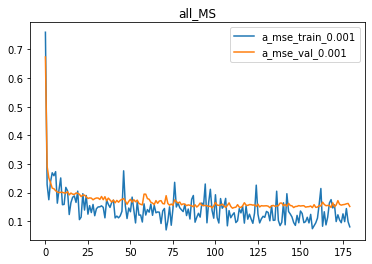

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [191.63654   13.801502]
Loss MAPE
 [0.1276051, 0.14608301]
Loss RMSE
 [349.87888   23.443377]
Loss R2
 [0.8428248508112595, 0.8391850977286107]
Loss MAE
 [191.63649, 13.8015]
Loss MAPE
 [1.5589291e+16, 555567600000000.0]
Loss RMSE
 [349.878840636298, 23.443376867365174]
Loss R2
 [0.839870028934691, 0.8379248348147308]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


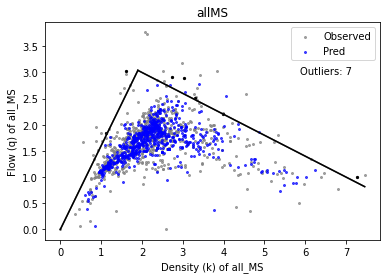

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.26255269 3.85121341]
Loss MAPE
 [0.609316985907886, 0.42902330580374803]
Loss RMSE
 [2.05134035 5.07828379]
Loss R2
 [0.6936760939839014, 0.5898579067326339]
##################################################################
7 Scen10_qk 0.6
##################################################################


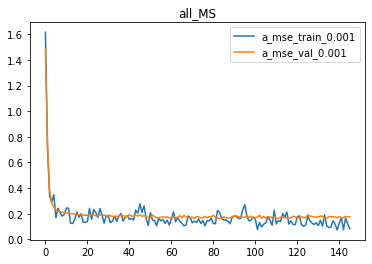

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [205.52551   14.262758]
Loss MAPE
 [0.14525221, 0.15562525]
Loss RMSE
 [365.30377   22.569069]
Loss R2
 [0.8514391467190787, 0.8394319398099686]
Loss MAE
 [205.52556, 14.262766]
Loss MAPE
 [1.8840591e+16, 458123060000000.0]
Loss RMSE
 [365.3036194386801, 22.569063114433465]
Loss R2
 [0.8200247504371179, 0.8386071023137391]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


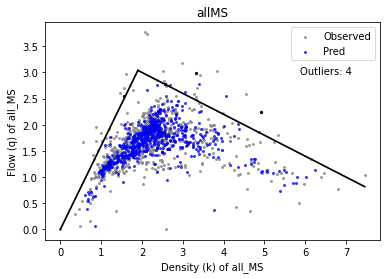

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.37945699 3.80600962]
Loss MAPE
 [0.5685500743002717, 0.4021167931764905]
Loss RMSE
 [2.32081403 5.55620556]
Loss R2
 [0.6219148909627639, 0.5598583256412882]
##################################################################
7 Scen11_qk 0.6
##################################################################


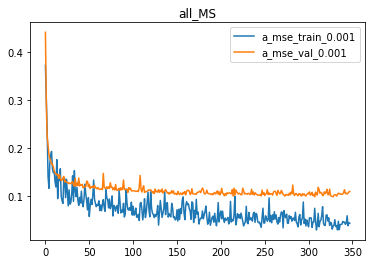

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [158.89082   12.335186]
Loss MAPE
 [0.14962783, 0.14381994]
Loss RMSE
 [290.30682   19.534147]
Loss R2
 [0.8957057303659766, 0.8909652566458538]
Loss MAE
 [158.8909, 12.335186]
Loss MAPE
 [1.2828319e+16, 320737320000000.0]
Loss RMSE
 [290.3068554349001, 19.5341536904057]
Loss R2
 [0.8937285404564981, 0.8869656042083593]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


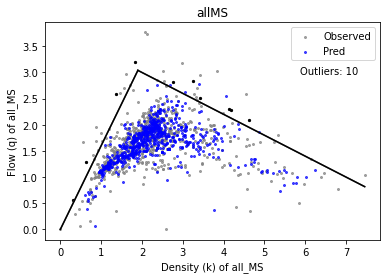

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.09053361 3.97688299]
Loss MAPE
 [0.46355029982923324, 0.3760349852721122]
Loss RMSE
 [2.04047751 5.79847802]
Loss R2
 [0.8257254542731256, 0.6049046507176247]
##################################################################
8 Scen0_qk 0.6
##################################################################


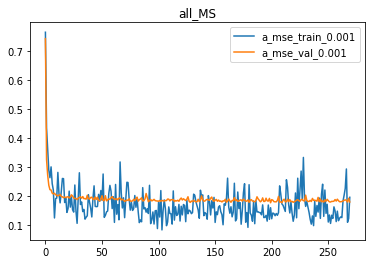

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [178.1184    16.080082]
Loss MAPE
 [0.13875037, 0.1980631]
Loss RMSE
 [329.73166   28.756186]
Loss R2
 [0.8661233044840304, 0.7799522453225884]
Loss MAE
 [178.1184, 16.080076]
Loss MAPE
 [5460267000000000.0, 85387670000000.0]
Loss RMSE
 [329.73174466147475, 28.756186706964144]
Loss R2
 [0.8608885112680589, 0.7732070509200955]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


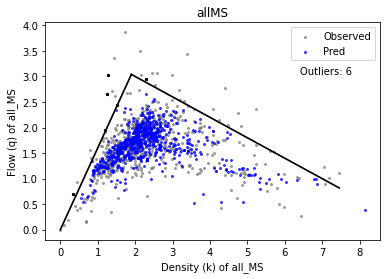

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.29320705 3.91445664]
Loss MAPE
 [0.6141517643918761, 0.43481197196131005]
Loss RMSE
 [2.33185181 5.45881909]
Loss R2
 [0.6030665649807174, 0.5984114569016802]
##################################################################
8 Scen1_qk 0.6
##################################################################


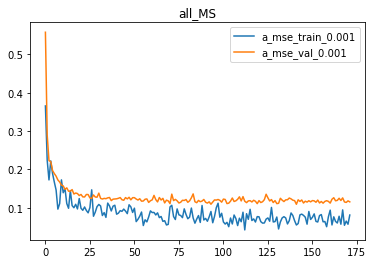

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [161.18524   12.221603]
Loss MAPE
 [0.12755807, 0.14959823]
Loss RMSE
 [282.71967  19.32772]
Loss R2
 [0.8974551386043982, 0.889080047401872]
Loss MAE
 [161.18521, 12.2216015]
Loss MAPE
 [5111600000000000.0, 0.14959823]
Loss RMSE
 [282.7197016260098, 19.327719213100877]
Loss R2
 [0.8955752507499921, 0.8878730328082506]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


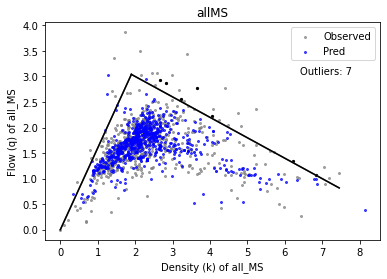

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.02901566 3.76084391]
Loss MAPE
 [0.4326888376031729, 0.4457248373292477]
Loss RMSE
 [1.77031226 5.23991981]
Loss R2
 [0.756414106785737, 0.6014225394841491]
##################################################################
8 Scen3_qk 0.6
##################################################################


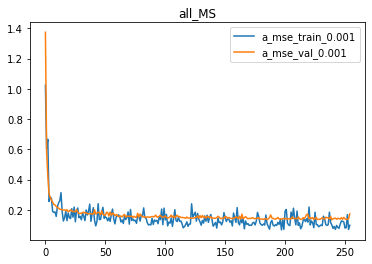

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 18
Loss MAE
 [186.24881   16.962076]
Loss MAPE
 [0.15042731, 0.19593862]
Loss RMSE
 [346.0602    27.925644]
Loss R2
 [0.8672644727219849, 0.8304978210536513]
Loss MAE
 [186.2488, 16.962078]
Loss MAPE
 [4934904500000000.0, 102434100000000.0]
Loss RMSE
 [346.0602480963394, 27.925645468004628]
Loss R2
 [0.8467695911838322, 0.7861184201382799]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


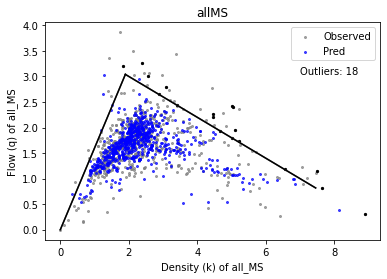

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.16585022 3.57814117]
Loss MAPE
 [0.5108441674058428, 0.3801168530244286]
Loss RMSE
 [2.16518692 4.95881366]
Loss R2
 [0.6459498986722114, 0.6212516822645485]
##################################################################
8 Scen10_qk 0.6
##################################################################


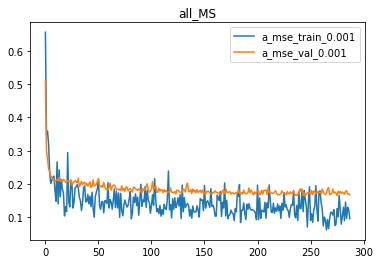

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [196.154     14.718159]
Loss MAPE
 [0.11483306, 0.14735295]
Loss RMSE
 [369.6373    24.663235]
Loss R2
 [0.8274921518101704, 0.8248320298047374]
Loss MAE
 [196.15402, 14.718162]
Loss MAPE
 [3.892189e+16, 1206431800000000.0]
Loss RMSE
 [369.63736452095856, 24.66323718725276]
Loss R2
 [0.8164701386577172, 0.8192876238933253]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


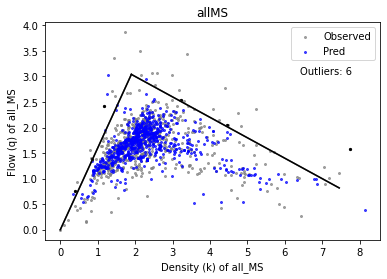

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.16000631 3.68213638]
Loss MAPE
 [0.6029236522084405, 0.39383392893677294]
Loss RMSE
 [2.14515679 4.90590552]
Loss R2
 [0.6362748794054258, 0.61682635072506]
##################################################################
8 Scen11_qk 0.6
##################################################################


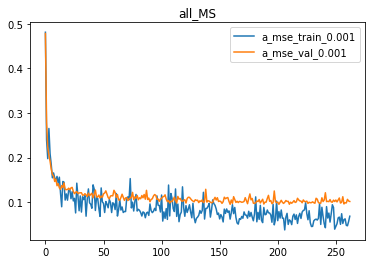

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 17
Loss MAE
 [173.12938   10.661461]
Loss MAPE
 [0.1153286, 0.120147206]
Loss RMSE
 [283.65527  16.84673]
Loss R2
 [0.9062834188221051, 0.9172138017338933]
Loss MAE
 [173.12944, 10.66145]
Loss MAPE
 [1.4534619e+16, 459250550000000.0]
Loss RMSE
 [283.65540824211337, 16.846724719928872]
Loss R2
 [0.8947506687927449, 0.9163035371430773]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


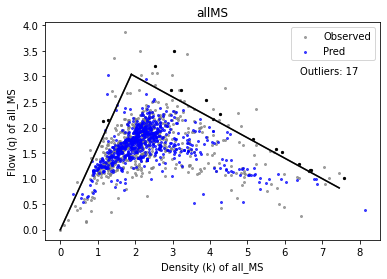

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [0.99953784 3.75152479]
Loss MAPE
 [0.4481256624218302, 0.4212745100506272]
Loss RMSE
 [1.6305435  4.95166705]
Loss R2
 [0.7914375098690783, 0.6091733591497311]
##################################################################
9 Scen0_qk 0.6
##################################################################


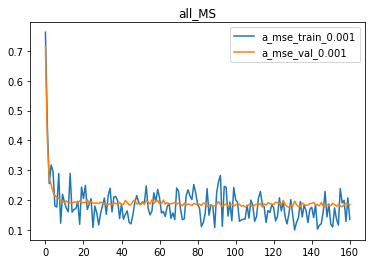

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [169.05663   16.917347]
Loss MAPE
 [0.13964404, 0.19035235]
Loss RMSE
 [344.27676   28.623037]
Loss R2
 [0.8555439851258313, 0.753897651402009]
Loss MAE
 [169.05663, 16.917345]
Loss MAPE
 [1.2485327e+16, 449448230000000.0]
Loss RMSE
 [344.27676684246353, 28.62304147741761]
Loss R2
 [0.8439338856959564, 0.7274917557624574]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


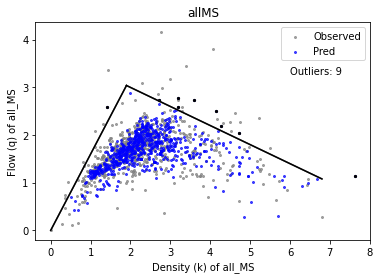

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.27323078 3.57726334]
Loss MAPE
 [0.5611039928490338, 0.39262216541755685]
Loss RMSE
 [2.22872628 5.07874503]
Loss R2
 [0.6233652511684341, 0.6092052834099837]
##################################################################
9 Scen1_qk 0.6
##################################################################


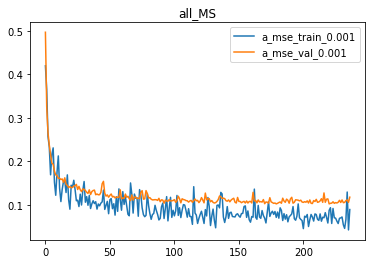

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [156.70813   13.614404]
Loss MAPE
 [0.13765709, 0.16246124]
Loss RMSE
 [282.79453   20.955185]
Loss R2
 [0.9078408884069996, 0.8674287666520024]
Loss MAE
 [156.7082, 13.6144]
Loss MAPE
 [9836412000000000.0, 398217200000000.0]
Loss RMSE
 [282.79437096590163, 20.95518434604102]
Loss R2
 [0.8946984603524042, 0.8539400869922587]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


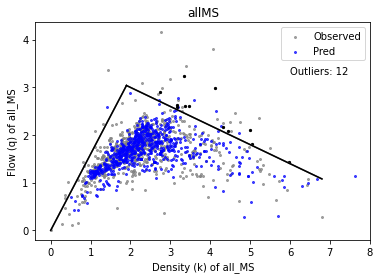

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.07251732 3.87266731]
Loss MAPE
 [0.5525498450687043, 0.3255886502862375]
Loss RMSE
 [1.90346681 5.59606427]
Loss R2
 [0.7558197692535237, 0.5776862499367399]
##################################################################
9 Scen3_qk 0.6
##################################################################


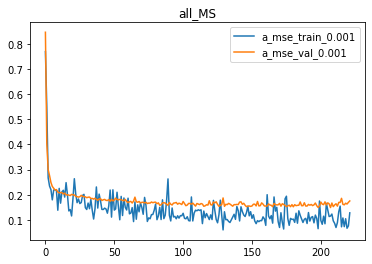

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [219.04245   14.548632]
Loss MAPE
 [0.1461588, 0.14927664]
Loss RMSE
 [375.54623  24.97979]
Loss R2
 [0.8450483145095689, 0.8261169329533852]
Loss MAE
 [219.04237, 14.548634]
Loss MAPE
 [1.6294341e+16, 562596960000000.0]
Loss RMSE
 [375.5461647720557, 24.979801410652268]
Loss R2
 [0.8155137789715379, 0.8159846252421258]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


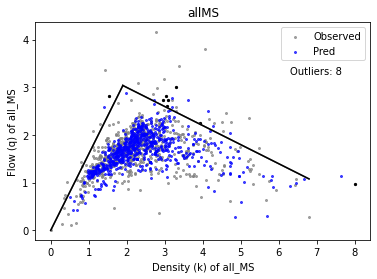

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.30560707 3.99836781]
Loss MAPE
 [0.4735503441593322, 0.4038124229515236]
Loss RMSE
 [2.11410579 5.53556957]
Loss R2
 [0.6927784395106471, 0.5809598052932103]
##################################################################
9 Scen10_qk 0.6
##################################################################


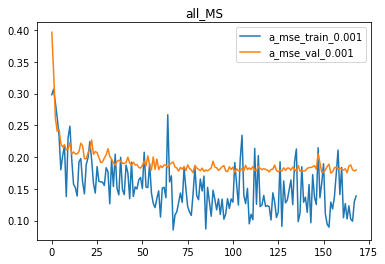

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [203.9603    14.602144]
Loss MAPE
 [0.123524725, 0.14501572]
Loss RMSE
 [415.5182   25.13691]
Loss R2
 [0.7957836417089467, 0.8158341116151897]
Loss MAE
 [203.9602, 14.602147]
Loss MAPE
 [3.5727988e+16, 1070554500000000.0]
Loss RMSE
 [415.51821936589016, 25.136911481875735]
Loss R2
 [0.7680816483440347, 0.8122795423735315]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


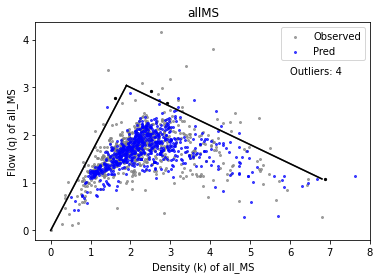

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.34239321 3.89204768]
Loss MAPE
 [0.675841633065256, 0.42680419322751917]
Loss RMSE
 [2.3707594  5.42045882]
Loss R2
 [0.6173754655158162, 0.6017288787031345]
##################################################################
9 Scen11_qk 0.6
##################################################################


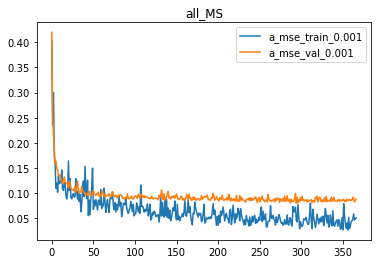

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [170.44586   11.817995]
Loss MAPE
 [0.1504842, 0.14918357]
Loss RMSE
 [301.95422  21.74397]
Loss R2
 [0.8998361574398726, 0.8713886769900528]
Loss MAE
 [170.44586, 11.817992]
Loss MAPE
 [1818426600000000.0, 90797180000000.0]
Loss RMSE
 [301.95423390805433, 21.74397352190911]
Loss R2
 [0.8833395325329254, 0.8703284176161802]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


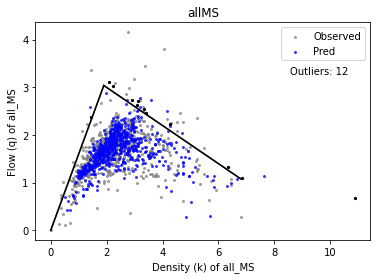

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.298857  4.0178612]
Loss MAPE
 [0.3921514537205864, 0.42043974113558785]
Loss RMSE
 [3.1872307  7.39741271]
Loss R2
 [0.5276388405744548, 0.4289811343938853]
##################################################################
10 Scen0_qk 0.6
##################################################################


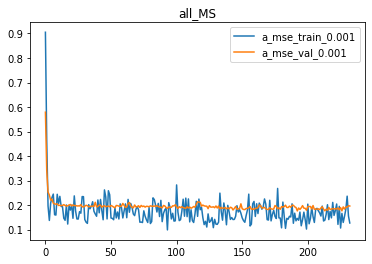

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 2
Loss MAE
 [205.47418  16.00142]
Loss MAPE
 [0.12442585, 0.16620159]
Loss RMSE
 [370.24005   27.080608]
Loss R2
 [0.8296905341498925, 0.7871513673328868]
Loss MAE
 [205.47418, 16.001415]
Loss MAPE
 [1.5508912e+16, 574413600000000.0]
Loss RMSE
 [370.2400403792113, 27.080616725733808]
Loss R2
 [0.8206902047060611, 0.7837315253828135]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


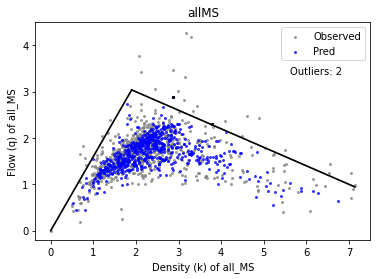

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.29428361 3.64095848]
Loss MAPE
 [0.5520489804545754, 0.4218301499340125]
Loss RMSE
 [2.19922916 5.24284728]
Loss R2
 [0.6265233498276881, 0.5936754109256868]
##################################################################
10 Scen1_qk 0.6
##################################################################


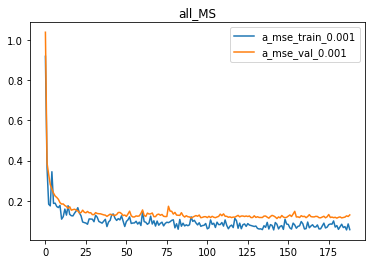

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [171.24057   13.362893]
Loss MAPE
 [0.12861101, 0.153081]
Loss RMSE
 [282.91727   20.254383]
Loss R2
 [0.9039416597725741, 0.8903605127261355]
Loss MAE
 [171.24063, 13.3628845]
Loss MAPE
 [4420620900000000.0, 0.153081]
Loss RMSE
 [282.9172388924012, 20.25438049408618]
Loss R2
 [0.8954292721087673, 0.8768635157801739]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


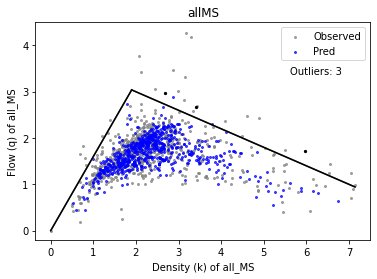

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.18524102 4.08125689]
Loss MAPE
 [0.47413991746311274, 0.46132347004020363]
Loss RMSE
 [1.91465551 5.53086538]
Loss R2
 [0.7263110262408422, 0.586788453117898]
##################################################################
10 Scen3_qk 0.6
##################################################################


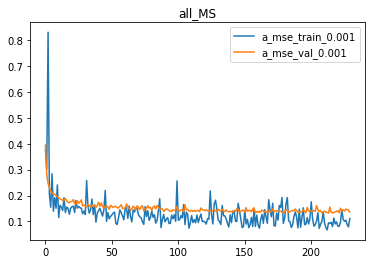

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [163.83728   13.530477]
Loss MAPE
 [0.12142683, 0.15066062]
Loss RMSE
 [302.0712   24.00645]
Loss R2
 [0.8855232188805606, 0.8433664272635328]
Loss MAE
 [163.83719, 13.530479]
Loss MAPE
 [3611804400000000.0, 58904105000000.0]
Loss RMSE
 [302.07118366371856, 24.006459956205667]
Loss R2
 [0.8832491435628762, 0.8419395450928528]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


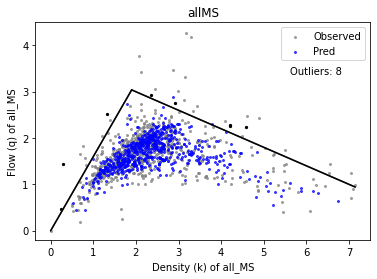

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.23175346 3.80496847]
Loss MAPE
 [0.5806650221846806, 0.38863674355231204]
Loss RMSE
 [2.12058987 5.34288806]
Loss R2
 [0.6660665454943213, 0.6067135332240985]
##################################################################
10 Scen10_qk 0.6
##################################################################


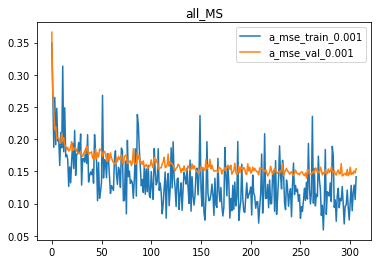

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [179.42828   16.272636]
Loss MAPE
 [0.1366331, 0.18674679]
Loss RMSE
 [326.0557    30.453432]
Loss R2
 [0.8655661055458393, 0.7662795041173383]
Loss MAE
 [179.42824, 16.272635]
Loss MAPE
 [6888696000000000.0, 214025270000000.0]
Loss RMSE
 [326.0557132224491, 30.45342863977665]
Loss R2
 [0.8639729949100257, 0.7456455366821809]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


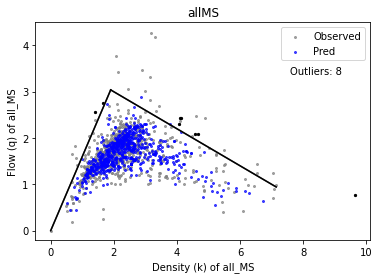

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.15717906 4.17310813]
Loss MAPE
 [0.5550405553007648, 0.4565528549453114]
Loss RMSE
 [2.21627781 5.56352733]
Loss R2
 [0.5529467070544165, 0.5374859091529527]
##################################################################
10 Scen11_qk 0.6
##################################################################


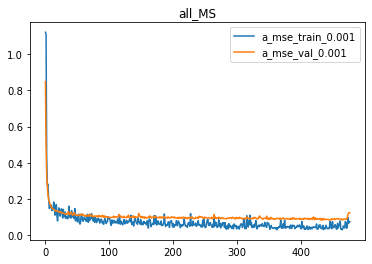

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [194.66039   13.249163]
Loss MAPE
 [0.17679787, 0.15637265]
Loss RMSE
 [320.93008   20.144737]
Loss R2
 [0.8689700007849381, 0.8960801183018005]
Loss MAE
 [194.66052, 13.249157]
Loss MAPE
 [0.17679787, 0.15637265]
Loss RMSE
 [320.93009363411215, 20.14473311356586]
Loss R2
 [0.8659566428945886, 0.8693060244474693]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


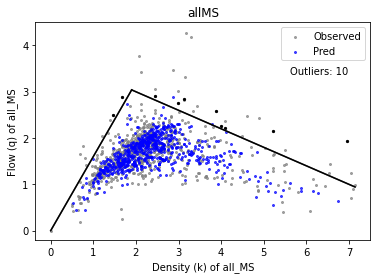

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.02785465 3.75402327]
Loss MAPE
 [0.42115808010933675, 0.4206756254237147]
Loss RMSE
 [1.6125031  4.96068439]
Loss R2
 [0.7940507941419981, 0.6134053575843245]
##################################################################
11 Scen0_qk 0.6
##################################################################


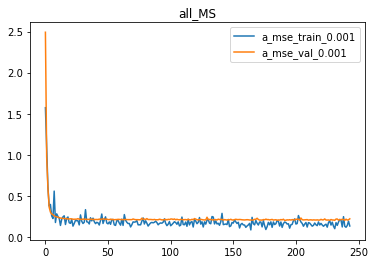

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 19
Loss MAE
 [253.96681   17.159569]
Loss MAPE
 [0.14866643, 0.173943]
Loss RMSE
 [474.76813   27.706888]
Loss R2
 [0.7728900503175946, 0.7891200712027223]
Loss MAE
 [253.9668, 17.159569]
Loss MAPE
 [3.9950897e+16, 1291793600000000.0]
Loss RMSE
 [474.76831520753365, 27.706893294542358]
Loss R2
 [0.6972261190381813, 0.771932508404721]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


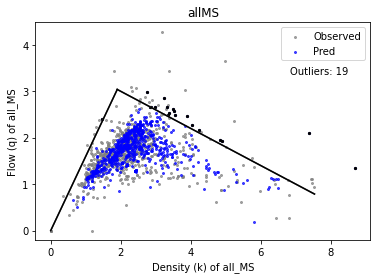

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.37037838 3.95655111]
Loss MAPE
 [0.6011720049264241, 0.46511500195058925]
Loss RMSE
 [2.67165817 5.52892342]
Loss R2
 [0.5109926628057136, 0.5385263309062657]
##################################################################
11 Scen1_qk 0.6
##################################################################


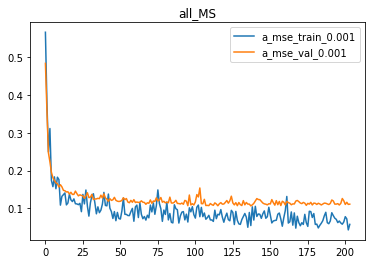

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [133.57301   12.346005]
Loss MAPE
 [0.12225949, 0.13555068]
Loss RMSE
 [265.5999    20.390543]
Loss R2
 [0.9080159296849337, 0.8682140149234692]
Loss MAE
 [133.573, 12.346015]
Loss MAPE
 [1.0964564e+16, 344235450000000.0]
Loss RMSE
 [265.5999694088838, 20.390543432547585]
Loss R2
 [0.9071142160220171, 0.8617052497896338]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


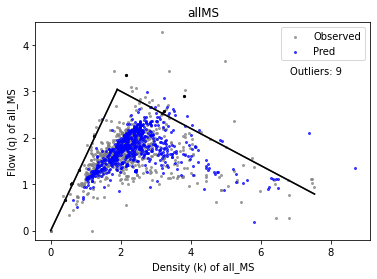

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.10853284 3.94833725]
Loss MAPE
 [0.4939502197664016, 0.4650112295843736]
Loss RMSE
 [1.86147185 5.2737529 ]
Loss R2
 [0.6800965017196136, 0.5993346307786072]
##################################################################
11 Scen3_qk 0.6
##################################################################


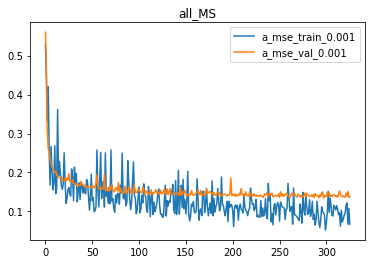

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [175.2291     14.4953785]
Loss MAPE
 [0.16042712, 0.17020051]
Loss RMSE
 [333.30615   23.356337]
Loss R2
 [0.864617668368779, 0.8409607301888526]
Loss MAE
 [175.22894, 14.495381]
Loss MAPE
 [1.8486476e+16, 522579400000000.0]
Loss RMSE
 [333.3061889989443, 23.356343866883897]
Loss R2
 [0.8599158965059637, 0.8384038035370219]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


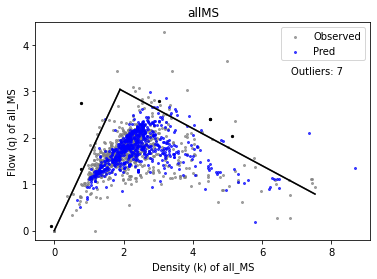

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.23555574 3.79760015]
Loss MAPE
 [0.5126045672897658, 0.3401072423204087]
Loss RMSE
 [2.28025907 5.37853643]
Loss R2
 [0.6413580128712103, 0.5833500157117055]
##################################################################
11 Scen10_qk 0.6
##################################################################


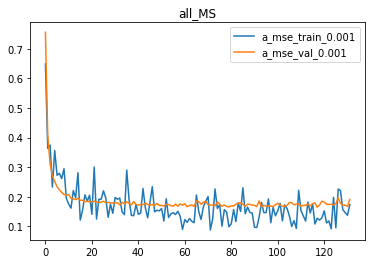

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [207.54712  17.28077]
Loss MAPE
 [0.16737336, 0.19831139]
Loss RMSE
 [358.74585   27.176472]
Loss R2
 [0.8451065577558974, 0.8214572513486171]
Loss MAE
 [207.5471, 17.280767]
Loss MAPE
 [1.850861e+16, 603940500000000.0]
Loss RMSE
 [358.74584056822175, 27.1764772015421]
Loss R2
 [0.8377159694470414, 0.7812199157872527]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


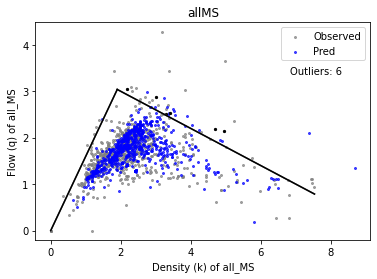

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.14663586 3.80739636]
Loss MAPE
 [0.5569250823203136, 0.4647077402016332]
Loss RMSE
 [2.08366072 5.37458167]
Loss R2
 [0.664750719185669, 0.5800068072760097]
##################################################################
11 Scen11_qk 0.6
##################################################################


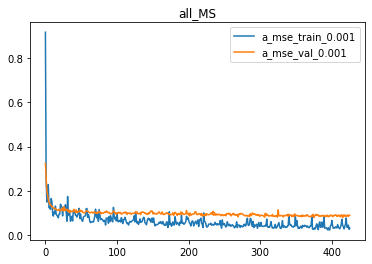

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [138.21121   12.223667]
Loss MAPE
 [0.123183206, 0.14245947]
Loss RMSE
 [286.67633   21.941572]
Loss R2
 [0.8969097717165059, 0.8747426998441403]
Loss MAE
 [138.21123, 12.223667]
Loss MAPE
 [2796383100000000.0, 35594684000000.0]
Loss RMSE
 [286.6762928374092, 21.941570719407615]
Loss R2
 [0.8948461856377175, 0.8679609443327605]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


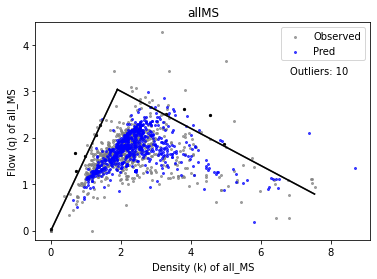

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.06662845 3.71647115]
Loss MAPE
 [0.39950006064878535, 0.4364415186269274]
Loss RMSE
 [1.58058556 5.20662343]
Loss R2
 [0.814997343256974, 0.5968665070936028]
##################################################################
12 Scen0_qk 0.6
##################################################################


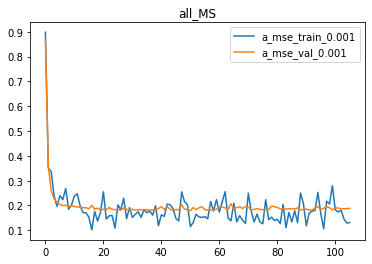

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [191.28609   16.658243]
Loss MAPE
 [0.16176283, 0.1882224]
Loss RMSE
 [354.81442   28.111382]
Loss R2
 [0.8437352462907461, 0.798597892263526]
Loss MAE
 [191.28606, 16.658228]
Loss MAPE
 [2.1912584e+16, 582604000000000.0]
Loss RMSE
 [354.81444314246846, 28.111385593741193]
Loss R2
 [0.8412533310542815, 0.7659083312777892]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


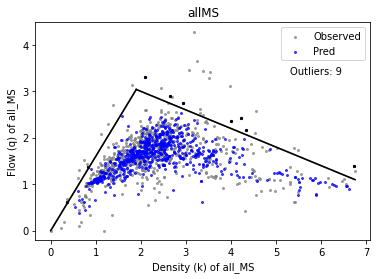

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.4016584  3.89173544]
Loss MAPE
 [0.5797896648288076, 0.42688022393303005]
Loss RMSE
 [2.3893392  5.63387808]
Loss R2
 [0.6040347567347603, 0.5740115914983834]
##################################################################
12 Scen1_qk 0.6
##################################################################


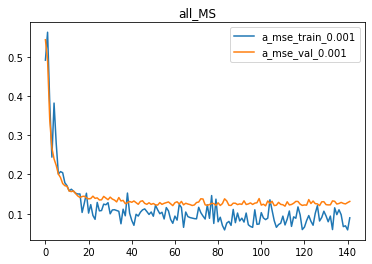

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [142.27603   11.354669]
Loss MAPE
 [0.12165061, 0.12487262]
Loss RMSE
 [247.89937   17.574541]
Loss R2
 [0.9191281082613227, 0.9031218468689128]
Loss MAE
 [142.27603, 11.354668]
Loss MAPE
 [1.5999906e+16, 365505100000000.0]
Loss RMSE
 [247.899377898574, 17.574541301357627]
Loss R2
 [0.91711886924905, 0.9021354687037582]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


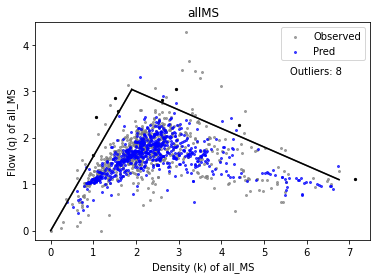

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.08167795 3.91942507]
Loss MAPE
 [0.5432527126073091, 0.4598091968919496]
Loss RMSE
 [1.8836772  5.19902782]
Loss R2
 [0.6809357266928571, 0.6081510306720453]
##################################################################
12 Scen3_qk 0.6
##################################################################


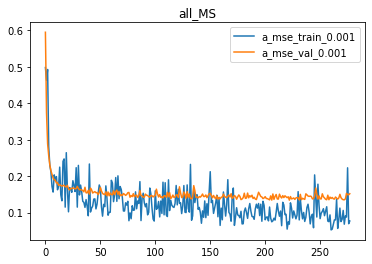

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [180.66498   15.265046]
Loss MAPE
 [0.15490672, 0.17366636]
Loss RMSE
 [327.36502   24.719269]
Loss R2
 [0.8687494783796648, 0.8282654794375076]
Loss MAE
 [180.665, 15.26504]
Loss MAPE
 [1.586905e+16, 539243880000000.0]
Loss RMSE
 [327.3650604638498, 24.719278399851703]
Loss R2
 [0.8648653509491001, 0.8189939864266897]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


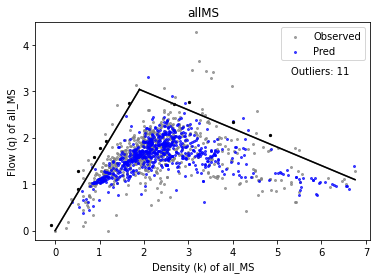

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.1765731  3.59338073]
Loss MAPE
 [0.5366225589270376, 0.3468111263353412]
Loss RMSE
 [2.02400225 4.96692856]
Loss R2
 [0.6894616050314611, 0.6259213141734016]
##################################################################
12 Scen10_qk 0.6
##################################################################


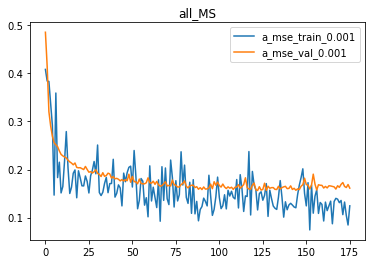

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [165.40662   14.410227]
Loss MAPE
 [0.11164651, 0.14109147]
Loss RMSE
 [291.72098   24.973814]
Loss R2
 [0.8882588919454795, 0.8283248380441847]
Loss MAE
 [165.40668, 14.410223]
Loss MAPE
 [7613206000000000.0, 290198660000000.0]
Loss RMSE
 [291.72097113509, 24.973820521213433]
Loss R2
 [0.8838861843669332, 0.8264028621311457]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


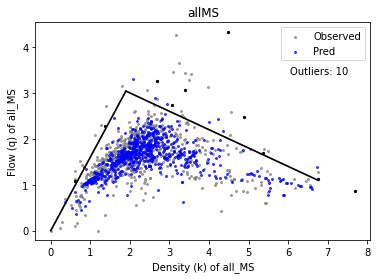

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.26334637 3.66826814]
Loss MAPE
 [0.5974712648589913, 0.40508266455416836]
Loss RMSE
 [2.60902335 5.16198088]
Loss R2
 [0.5361568236753803, 0.5738068679616889]
##################################################################
12 Scen11_qk 0.6
##################################################################


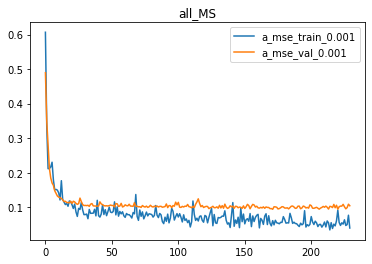

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [139.50162   12.113668]
Loss MAPE
 [0.12376768, 0.14132382]
Loss RMSE
 [269.568     21.468025]
Loss R2
 [0.9088101424605023, 0.8802220710746881]
Loss MAE
 [139.50157, 12.113666]
Loss MAPE
 [1537739200000000.0, 60631256000000.0]
Loss RMSE
 [269.5678978708333, 21.468017210246806]
Loss R2
 [0.9070225029447039, 0.8735989123895692]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


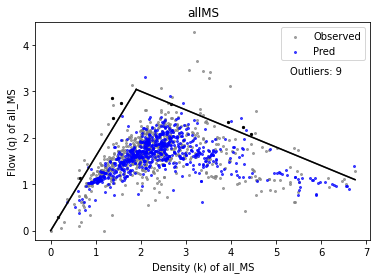

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.00086622 3.73387858]
Loss MAPE
 [0.4285111801705229, 0.3561788591731735]
Loss RMSE
 [1.60828058 5.19126553]
Loss R2
 [0.8333748871218923, 0.6045968286900409]
##################################################################
13 Scen0_qk 0.6
##################################################################


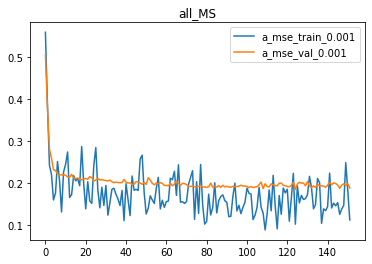

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [174.60233   14.960301]
Loss MAPE
 [0.11642569, 0.14327246]
Loss RMSE
 [325.15894   26.925028]
Loss R2
 [0.8637147044607225, 0.7986362826661457]
Loss MAE
 [174.6025, 14.960303]
Loss MAPE
 [8387427000000000.0, 327032130000000.0]
Loss RMSE
 [325.1590596346656, 26.92502838104934]
Loss R2
 [0.8557418879503872, 0.7982168354084704]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


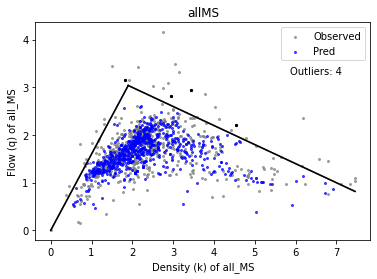

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.25829975 3.72325188]
Loss MAPE
 [0.4975591512966082, 0.3303096906627767]
Loss RMSE
 [2.37831121 5.32883033]
Loss R2
 [0.6275292340021177, 0.6004019195110203]
##################################################################
13 Scen1_qk 0.6
##################################################################


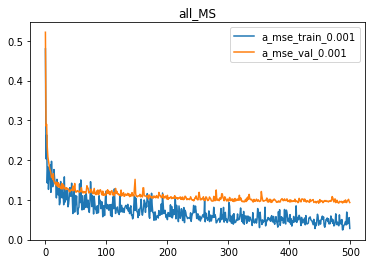

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [126.14754   10.752749]
Loss MAPE
 [0.0891054, 0.13161829]
Loss RMSE
 [218.93549  17.38076]
Loss R2
 [0.9346217943680758, 0.9160601863178752]
Loss MAE
 [126.147545, 10.752753]
Loss MAPE
 [3603062000000000.0, 0.13161829]
Loss RMSE
 [218.93544817765348, 17.380755671851826]
Loss R2
 [0.932094977123876, 0.9086875111530701]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


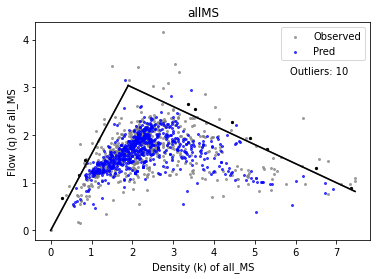

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.1252842  3.94767995]
Loss MAPE
 [0.5039896506081584, 0.4287010876543349]
Loss RMSE
 [2.08078974 5.72270148]
Loss R2
 [0.716635741534519, 0.5811169550560124]
##################################################################
13 Scen3_qk 0.6
##################################################################


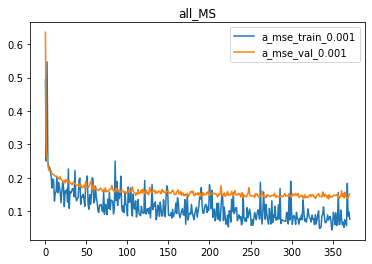

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 15
Loss MAE
 [173.31363   14.318344]
Loss MAPE
 [0.120441, 0.14634384]
Loss RMSE
 [323.8337    25.273848]
Loss R2
 [0.864606308714951, 0.816336993126978]
Loss MAE
 [173.31363, 14.318337]
Loss MAPE
 [1.6343403e+16, 544051260000000.0]
Loss RMSE
 [323.8337005702155, 25.27384321544522]
Loss R2
 [0.8628229768987656, 0.8116269636495755]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


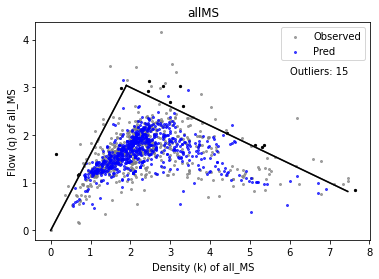

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.20415575 3.95870201]
Loss MAPE
 [0.5542953403034108, 0.4246044308318493]
Loss RMSE
 [2.03274346 5.49828765]
Loss R2
 [0.6927213620250152, 0.5922532843980348]
##################################################################
13 Scen10_qk 0.6
##################################################################


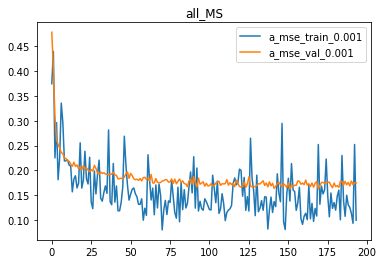

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [169.30827   14.530467]
Loss MAPE
 [0.112514526, 0.14645322]
Loss RMSE
 [290.6196   25.09324]
Loss R2
 [0.887880138924021, 0.8254526672602962]
Loss MAE
 [169.30823, 14.530455]
Loss MAPE
 [7995735500000000.0, 296483300000000.0]
Loss RMSE
 [290.61963704729243, 25.093246511916558]
Loss R2
 [0.884761271538038, 0.82473858599354]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


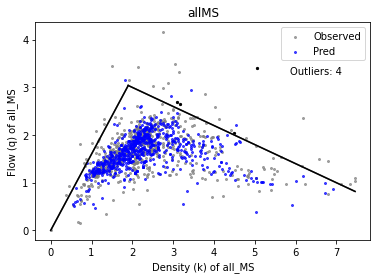

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.22211563 3.84988191]
Loss MAPE
 [0.5682547428911918, 0.4435433822655665]
Loss RMSE
 [2.17116974 5.10399234]
Loss R2
 [0.6309150954070587, 0.6158176827364585]
##################################################################
13 Scen11_qk 0.6
##################################################################


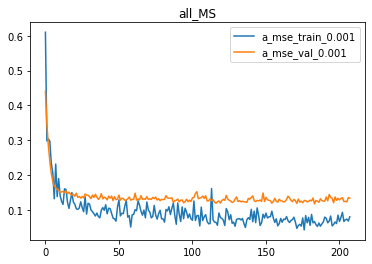

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 19
Loss MAE
 [164.01663   11.840541]
Loss MAPE
 [0.13973454, 0.13586456]
Loss RMSE
 [252.8689    18.719433]
Loss R2
 [0.9281497305572263, 0.8960320858758536]
Loss MAE
 [164.0166, 11.840542]
Loss MAPE
 [1.4420778e+16, 319537500000000.0]
Loss RMSE
 [252.868813258476, 18.71943309218975]
Loss R2
 [0.9137626562629737, 0.888969384800577]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


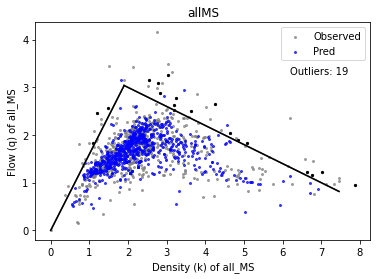

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.0019883  3.57846317]
Loss MAPE
 [0.4507007288233756, 0.3653136128947833]
Loss RMSE
 [1.61110382 5.00417934]
Loss R2
 [0.8052643881591947, 0.6204659288782527]
##################################################################
14 Scen0_qk 0.6
##################################################################


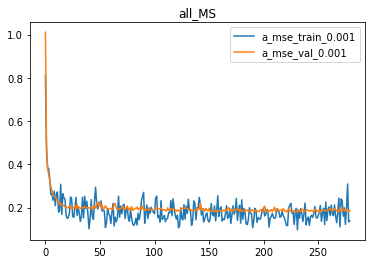

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [187.73631   15.526959]
Loss MAPE
 [0.14884822, 0.1697227]
Loss RMSE
 [343.77988   27.359838]
Loss R2
 [0.8616717371279361, 0.7600036732515666]
Loss MAE
 [187.7362, 15.526959]
Loss MAPE
 [1.2550042e+16, 431790640000000.0]
Loss RMSE
 [343.7798396139599, 27.359839016624804]
Loss R2
 [0.844384072297516, 0.7510138629558578]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


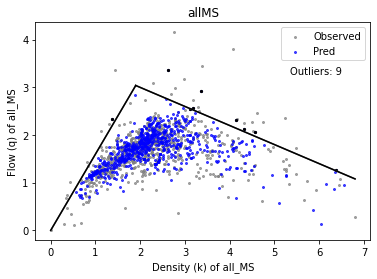

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.30849957 3.8071119 ]
Loss MAPE
 [0.6257763119936526, 0.3911085304407157]
Loss RMSE
 [2.38954032 5.54350156]
Loss R2
 [0.5910728500542014, 0.5625075853235443]
##################################################################
14 Scen1_qk 0.6
##################################################################


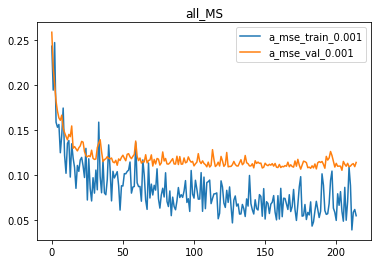

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [153.07684   12.269635]
Loss MAPE
 [0.14010341, 0.14180848]
Loss RMSE
 [282.30807   19.689774]
Loss R2
 [0.899912098179939, 0.8916543102812033]
Loss MAE
 [153.07693, 12.269631]
Loss MAPE
 [1.4164527e+16, 283290070000000.0]
Loss RMSE
 [282.30816218717445, 19.68977386422248]
Loss R2
 [0.8995039727023775, 0.8851574355304316]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


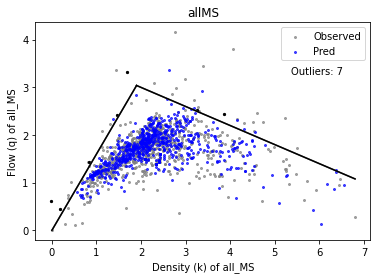

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [2.6935176  6.12583548]
Loss MAPE
 [0.45131700925932255, 1.2644307490718547]
Loss RMSE
 [39.77854575 64.57725366]
Loss R2
 [0.0028813533733508642, 0.0010917004823913468]
##################################################################
14 Scen3_qk 0.6
##################################################################


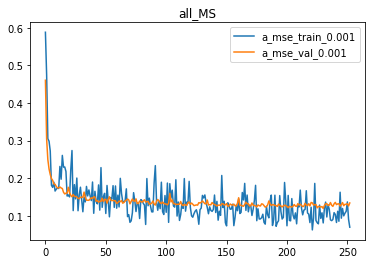

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [159.68169   13.202839]
Loss MAPE
 [0.13569513, 0.15786055]
Loss RMSE
 [293.8848    22.314732]
Loss R2
 [0.8917828062197968, 0.8412979831016446]
Loss MAE
 [159.68167, 13.20284]
Loss MAPE
 [0.13569513, 0.15786055]
Loss RMSE
 [293.8848493670608, 22.31473339881425]
Loss R2
 [0.8875967589187959, 0.8396326573392949]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


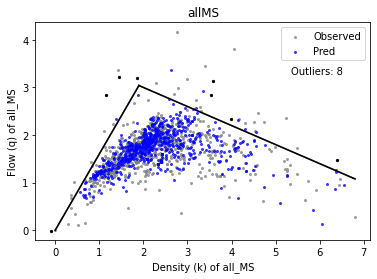

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.29279742 3.87187526]
Loss MAPE
 [0.5278242840895025, 0.4127101913073292]
Loss RMSE
 [2.20334247 5.57866108]
Loss R2
 [0.6599844220515418, 0.5741908518505667]
##################################################################
14 Scen10_qk 0.6
##################################################################


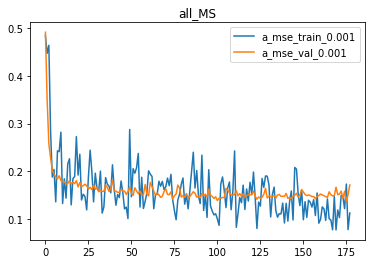

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [184.17317   14.317017]
Loss MAPE
 [0.15427372, 0.16022843]
Loss RMSE
 [347.9633    23.150604]
Loss R2
 [0.8584201523520568, 0.8301900822509853]
Loss MAE
 [184.17319, 14.317017]
Loss MAPE
 [0.15427372, 0.16022843]
Loss RMSE
 [347.96315807136824, 23.15061134536327]
Loss R2
 [0.8424236637154443, 0.8273933773714065]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


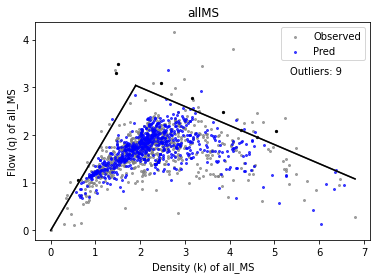

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.24288866 3.68600848]
Loss MAPE
 [0.575186114544804, 0.38652625923931366]
Loss RMSE
 [2.22335642 5.16810148]
Loss R2
 [0.6374453344599056, 0.6332754561652642]
##################################################################
14 Scen11_qk 0.6
##################################################################


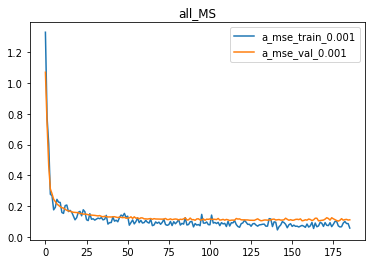

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [146.88824   12.280435]
Loss MAPE
 [0.12189195, 0.13521875]
Loss RMSE
 [271.95126   20.467793]
Loss R2
 [0.9032055178192983, 0.8630507169161267]
Loss MAE
 [146.88821, 12.280432]
Loss MAPE
 [1.0520334e+16, 348235580000000.0]
Loss RMSE
 [271.9512680380439, 20.467792797275127]
Loss R2
 [0.9026187384469743, 0.8606554200728697]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


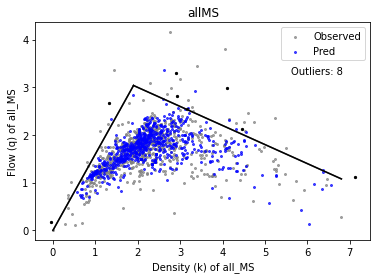

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.0883834  3.90880426]
Loss MAPE
 [0.44210254096816476, 0.4798872458906132]
Loss RMSE
 [1.66768093 5.16216951]
Loss R2
 [0.8065895882868451, 0.6281262939774742]
##################################################################
15 Scen0_qk 0.6
##################################################################


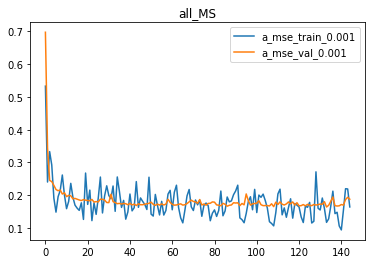

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 21
Loss MAE
 [215.44205  16.33539]
Loss MAPE
 [0.17601378, 0.18135318]
Loss RMSE
 [378.4452    26.311543]
Loss R2
 [0.8470504320676409, 0.7932158730737245]
Loss MAE
 [215.44196, 16.335386]
Loss MAPE
 [0.17601378, 0.18135318]
Loss RMSE
 [378.44523629582125, 26.311540817211394]
Loss R2
 [0.8136066103987613, 0.777040965100835]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


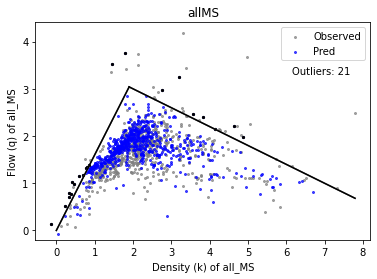

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.39093531 3.84931015]
Loss MAPE
 [0.5487877389523006, 0.4297176466641113]
Loss RMSE
 [2.30542547 5.30734617]
Loss R2
 [0.610138337397566, 0.6004422450875296]
##################################################################
15 Scen1_qk 0.6
##################################################################


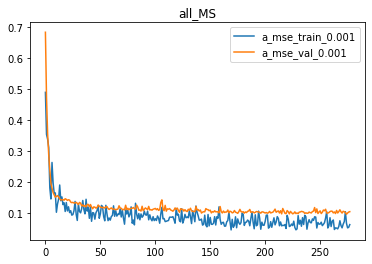

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 15
Loss MAE
 [142.28925   11.180879]
Loss MAPE
 [0.09351399, 0.13237046]
Loss RMSE
 [222.19534  17.05487]
Loss R2
 [0.9336840696965449, 0.922502308758351]
Loss MAE
 [142.28926, 11.180882]
Loss MAPE
 [4682275600000000.0, 0.13237046]
Loss RMSE
 [222.19531456018598, 17.05486464921739]
Loss R2
 [0.9300577597877175, 0.9120796465955179]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


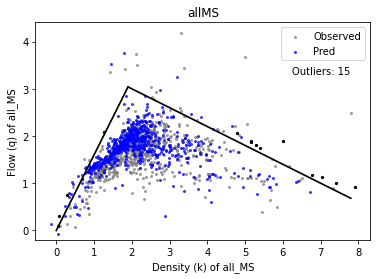

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.14122343 3.50493073]
Loss MAPE
 [0.3967370303958624, 0.3738275485908568]
Loss RMSE
 [1.76198411 4.99590766]
Loss R2
 [0.7776680510544429, 0.6126817805632473]
##################################################################
15 Scen3_qk 0.6
##################################################################


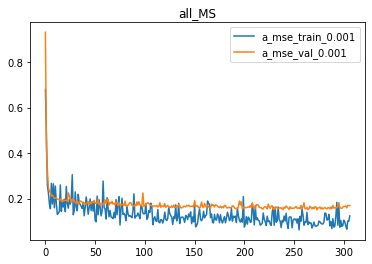

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 13
Loss MAE
 [179.00636   14.710419]
Loss MAPE
 [0.16115125, 0.16519132]
Loss RMSE
 [359.18854   24.618425]
Loss R2
 [0.8508851290186872, 0.811373532200254]
Loss MAE
 [179.00623, 14.710432]
Loss MAPE
 [1.2320501e+16, 451550950000000.0]
Loss RMSE
 [359.18845158217437, 24.61842715460121]
Loss R2
 [0.8301217046863754, 0.7984101300196614]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


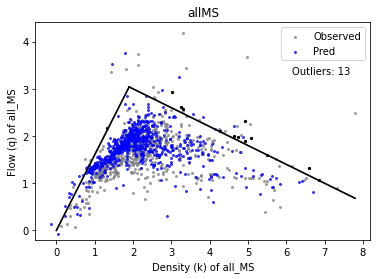

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.16598486 3.73526432]
Loss MAPE
 [0.5490883140341869, 0.4680182910431935]
Loss RMSE
 [1.87028568 5.35997944]
Loss R2
 [0.7311845523825314, 0.6014771663613049]
##################################################################
15 Scen10_qk 0.6
##################################################################


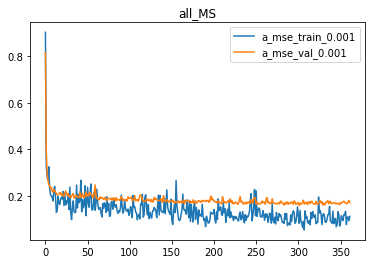

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [179.37364   15.342253]
Loss MAPE
 [0.14600962, 0.17586204]
Loss RMSE
 [321.73135   28.391441]
Loss R2
 [0.8816127015708911, 0.747098168524669]
Loss MAE
 [179.37354, 15.342246]
Loss MAPE
 [1.2665113e+16, 464608120000000.0]
Loss RMSE
 [321.7313392995777, 28.39143870084618]
Loss R2
 [0.863704990951657, 0.7318839190511032]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


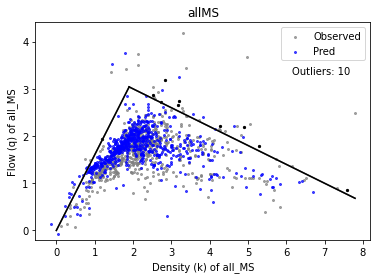

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.21459136 3.77956698]
Loss MAPE
 [0.5516134148236238, 0.46117049592036935]
Loss RMSE
 [2.05022105 5.40184357]
Loss R2
 [0.6738118330752344, 0.5866977666165237]
##################################################################
15 Scen11_qk 0.6
##################################################################


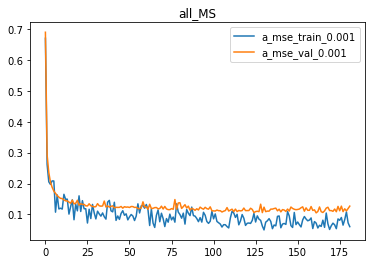

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [139.77754   11.836422]
Loss MAPE
 [0.08887439, 0.1342988]
Loss RMSE
 [227.95801   17.607458]
Loss R2
 [0.9310186264985473, 0.9172349738192586]
Loss MAE
 [139.7776, 11.836423]
Loss MAPE
 [3702435800000000.0, 0.1342988]
Loss RMSE
 [227.95807248812224, 17.6074598975255]
Loss R2
 [0.926382730853278, 0.9062899136466709]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


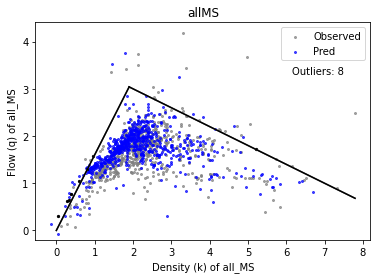

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.03109307 4.1861195 ]
Loss MAPE
 [0.43851431622458625, 0.3923612874036812]
Loss RMSE
 [1.90032332 5.98949856]
Loss R2
 [0.8442966438031025, 0.5984975143685981]
##################################################################
16 Scen0_qk 0.6
##################################################################


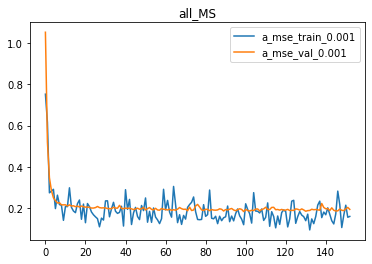

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [205.0885    15.350874]
Loss MAPE
 [0.12635387, 0.15928753]
Loss RMSE
 [383.7969    25.959227]
Loss R2
 [0.8146941941168414, 0.8041352403155759]
Loss MAE
 [205.0885, 15.35087]
Loss MAPE
 [1.4711873e+16, 590213060000000.0]
Loss RMSE
 [383.79680089208665, 25.95922353656006]
Loss R2
 [0.8073185323824698, 0.8012717976351135]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


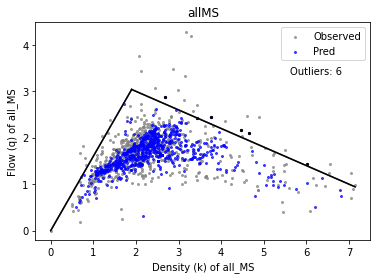

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.33592474 3.7924164 ]
Loss MAPE
 [0.5757339657198696, 0.43752363554471213]
Loss RMSE
 [2.64254924 5.2136258 ]
Loss R2
 [0.521935468749411, 0.5764213865250054]
##################################################################
16 Scen1_qk 0.6
##################################################################


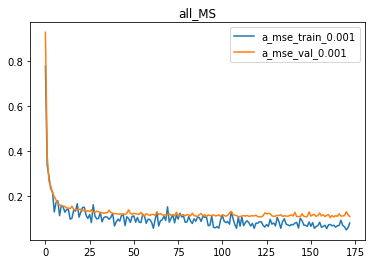

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [142.46497  11.10932]
Loss MAPE
 [0.09284038, 0.13470337]
Loss RMSE
 [222.68144  16.90293]
Loss R2
 [0.9309343539576269, 0.9139779816500074]
Loss MAE
 [142.46494, 11.109318]
Loss MAPE
 [4123976900000000.0, 0.13470337]
Loss RMSE
 [222.68137796805104, 16.902923764458897]
Loss R2
 [0.9297514131828291, 0.9136392271602104]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


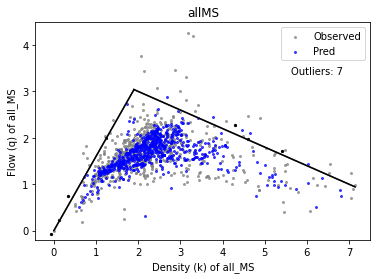

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.1139689  3.88500612]
Loss MAPE
 [0.42072566018281937, 0.4295283910972403]
Loss RMSE
 [1.71471848 5.41476587]
Loss R2
 [0.7784214250810735, 0.5895341912133019]
##################################################################
16 Scen3_qk 0.6
##################################################################


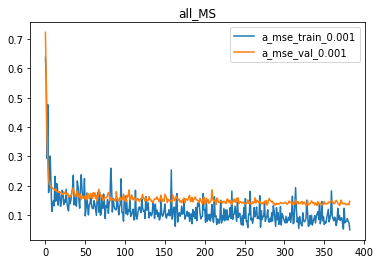

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [169.23544   12.422409]
Loss MAPE
 [0.12494653, 0.14052217]
Loss RMSE
 [295.49805  21.22503]
Loss R2
 [0.8870001326032758, 0.8582479790737721]
Loss MAE
 [169.23538, 12.422412]
Loss MAPE
 [1.893435e+16, 418122050000000.0]
Loss RMSE
 [295.49789815242343, 21.22502409772999]
Loss R2
 [0.8822357152696068, 0.857257367491681]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


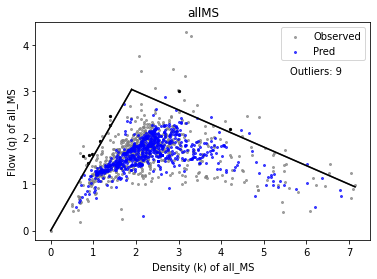

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.13474504 3.76768801]
Loss MAPE
 [0.5270642791947893, 0.4199368514097941]
Loss RMSE
 [1.889954   5.20330371]
Loss R2
 [0.7166489452490703, 0.6169471334751221]
##################################################################
16 Scen10_qk 0.6
##################################################################


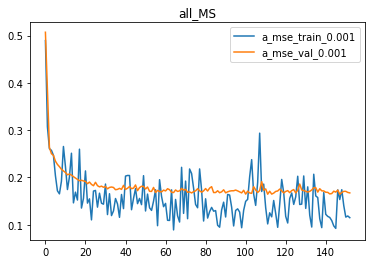

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 13
Loss MAE
 [182.51462   14.574671]
Loss MAPE
 [0.12178864, 0.1530868]
Loss RMSE
 [316.94058   25.213245]
Loss R2
 [0.8726554649592178, 0.8254578202079461]
Loss MAE
 [182.51465, 14.574673]
Loss MAPE
 [8564055000000000.0, 319329880000000.0]
Loss RMSE
 [316.94066134293973, 25.213243377272242]
Loss R2
 [0.8629419717757773, 0.8230583637605049]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


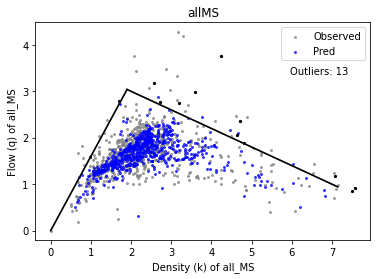

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.38758822 3.93050324]
Loss MAPE
 [0.6991293560279256, 0.412190518042193]
Loss RMSE
 [2.79976352 5.71432979]
Loss R2
 [0.5630455134494342, 0.6091275741704725]
##################################################################
16 Scen11_qk 0.6
##################################################################


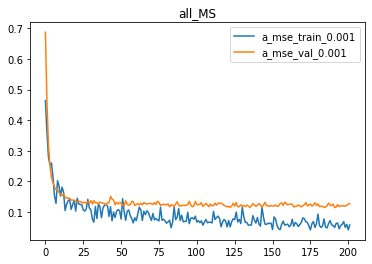

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [147.40063   11.469814]
Loss MAPE
 [0.13020505, 0.13203156]
Loss RMSE
 [252.81871   18.832132]
Loss R2
 [0.9165937063908994, 0.9042678246658757]
Loss MAE
 [147.40068, 11.469814]
Loss MAPE
 [1.2576875e+16, 283196820000000.0]
Loss RMSE
 [252.81874992274604, 18.832130506246415]
Loss R2
 [0.9137967961039747, 0.887628487880646]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


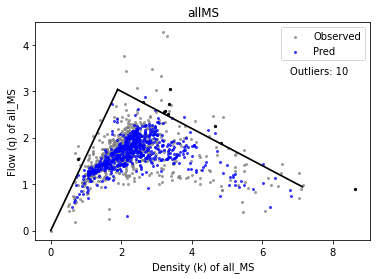

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [0.99627352 3.98376487]
Loss MAPE
 [0.40468338822886657, 0.40863885874731637]
Loss RMSE
 [1.72844597 5.76787393]
Loss R2
 [0.8508143790134991, 0.5981489929896505]
##################################################################
17 Scen0_qk 0.6
##################################################################


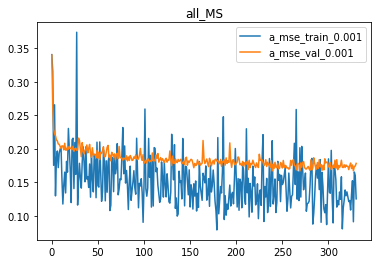

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 2
Loss MAE
 [177.81375   15.084093]
Loss MAPE
 [0.11465754, 0.15151836]
Loss RMSE
 [347.78      27.373722]
Loss R2
 [0.8435787601510811, 0.7804747946330362]
Loss MAE
 [177.81372, 15.084097]
Loss MAPE
 [1.5360734e+16, 563601600000000.0]
Loss RMSE
 [347.7801366344835, 27.373719067848064]
Loss R2
 [0.8417853144982421, 0.7790246772485401]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


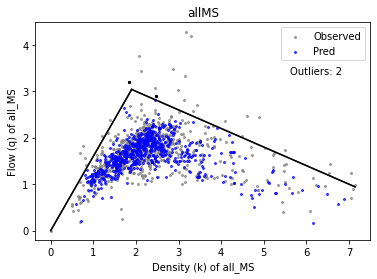

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.42887525 4.00332099]
Loss MAPE
 [0.606744552459798, 0.48245309154352733]
Loss RMSE
 [2.70459708 5.47542334]
Loss R2
 [0.5005948402832721, 0.5424431016822611]
##################################################################
17 Scen1_qk 0.6
##################################################################


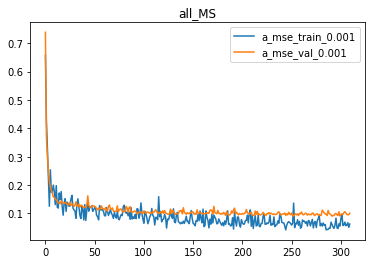

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [144.15164   11.892773]
Loss MAPE
 [0.13167442, 0.13531873]
Loss RMSE
 [265.04282   18.361742]
Loss R2
 [0.917674348156699, 0.8977954236074802]
Loss MAE
 [144.1516, 11.89277]
Loss MAPE
 [0.13167442, 0.13531873]
Loss RMSE
 [265.0428178851485, 18.36173771365974]
Loss R2
 [0.908576782699763, 0.8914174383698171]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


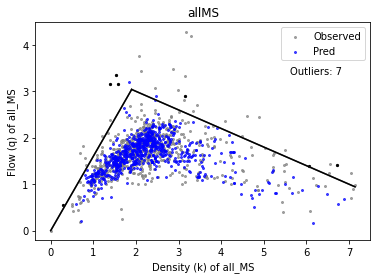

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.17355754 3.8375933 ]
Loss MAPE
 [0.5096987296532973, 0.39661490232098684]
Loss RMSE
 [2.08403602 5.54366056]
Loss R2
 [0.703414945700018, 0.5348329323326587]
##################################################################
17 Scen3_qk 0.6
##################################################################


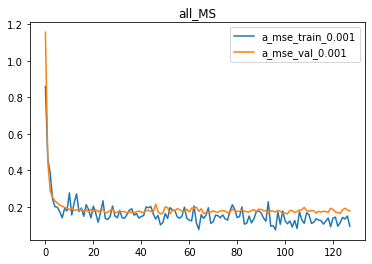

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [189.35835  14.16394]
Loss MAPE
 [0.13963118, 0.16637172]
Loss RMSE
 [343.6491    23.760841]
Loss R2
 [0.8594039633474853, 0.8244247853704635]
Loss MAE
 [189.35822, 14.163943]
Loss MAPE
 [1.9191035e+16, 439481320000000.0]
Loss RMSE
 [343.64924659818473, 23.760841224241066]
Loss R2
 [0.8407294101879472, 0.8211121093198723]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


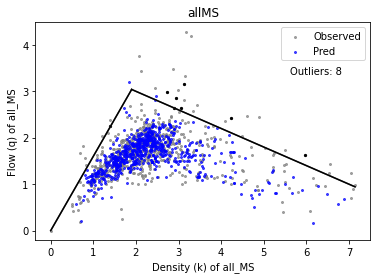

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.17261708 3.93625606]
Loss MAPE
 [0.5916219136972649, 0.3930204690891129]
Loss RMSE
 [2.07179424 5.53720314]
Loss R2
 [0.6888913743175347, 0.5919155588953608]
##################################################################
17 Scen10_qk 0.6
##################################################################


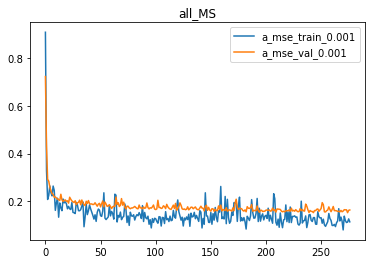

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [219.00946   15.850923]
Loss MAPE
 [0.17423785, 0.1911995]
Loss RMSE
 [383.43265   28.087057]
Loss R2
 [0.844756073256881, 0.7638596934995636]
Loss MAE
 [219.0096, 15.850925]
Loss MAPE
 [1594485300000000.0, 0.1911995]
Loss RMSE
 [383.4327475255602, 28.087052307499604]
Loss R2
 [0.8079254990870086, 0.7632111983670524]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


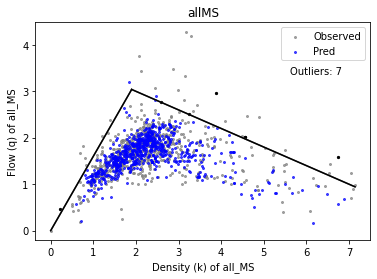

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.33887282 3.7800652 ]
Loss MAPE
 [0.5675174614646699, 0.4111062436388273]
Loss RMSE
 [2.66710398 5.27158786]
Loss R2
 [0.512932980282614, 0.5498266399458215]
##################################################################
17 Scen11_qk 0.6
##################################################################


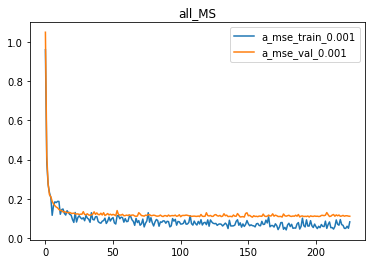

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 13
Loss MAE
 [164.018     11.988522]
Loss MAPE
 [0.1005901, 0.12671854]
Loss RMSE
 [295.68222   19.241213]
Loss R2
 [0.8853914635858032, 0.892026254004604]
Loss MAE
 [164.01797, 11.988521]
Loss MAPE
 [3.2167697e+16, 791719700000000.0]
Loss RMSE
 [295.682142997341, 19.24120813712517]
Loss R2
 [0.8825629292979077, 0.8900101930040466]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


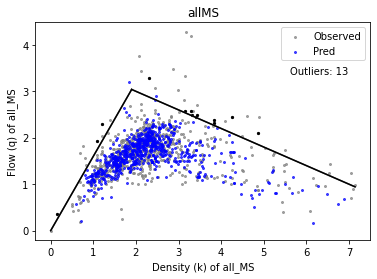

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.14966223 3.77624984]
Loss MAPE
 [0.4402240520099469, 0.43763101692268225]
Loss RMSE
 [1.70169284 5.01022027]
Loss R2
 [0.7792117277326399, 0.6350819522958528]
##################################################################
18 Scen0_qk 0.6
##################################################################


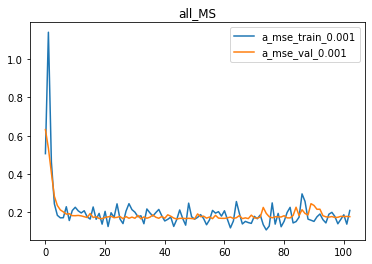

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [205.3837   14.41871]
Loss MAPE
 [0.14519146, 0.14775492]
Loss RMSE
 [375.9566    24.236431]
Loss R2
 [0.8298533263778668, 0.8169335695927494]
Loss MAE
 [205.38364, 14.418709]
Loss MAPE
 [1.9041063e+16, 421483230000000.0]
Loss RMSE
 [375.95646772598553, 24.236432556915993]
Loss R2
 [0.8093749600521998, 0.8138792812312677]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


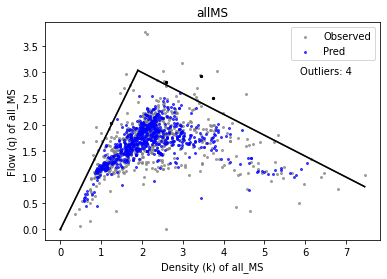

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.1325988  3.80837652]
Loss MAPE
 [0.5488487756713493, 0.33912258099168535]
Loss RMSE
 [2.3008754 5.3290819]
Loss R2
 [0.635835181394384, 0.5997975183995229]
##################################################################
18 Scen1_qk 0.6
##################################################################


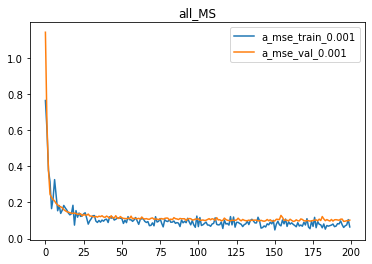

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [149.11505   13.123527]
Loss MAPE
 [0.10384893, 0.14077626]
Loss RMSE
 [241.70627   20.780258]
Loss R2
 [0.9260223428215105, 0.889021611612305]
Loss MAE
 [149.11504, 13.1235285]
Loss MAPE
 [5857686300000000.0, 222249800000000.0]
Loss RMSE
 [241.70627189835187, 20.78025726012253]
Loss R2
 [0.9202878790487442, 0.8798083136580273]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


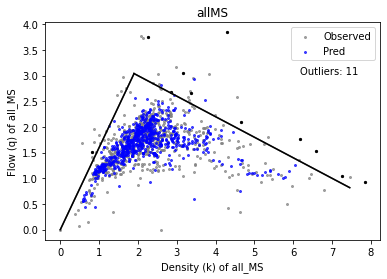

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.18844767 4.03917216]
Loss MAPE
 [0.542974349557982, 0.37974322700406327]
Loss RMSE
 [2.03267662 5.81506106]
Loss R2
 [0.773786037354046, 0.6205780431094916]
##################################################################
18 Scen3_qk 0.6
##################################################################


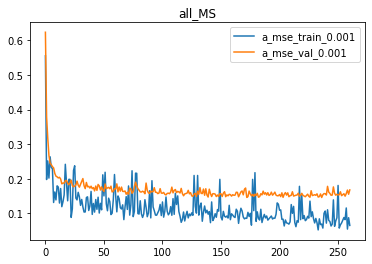

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [198.09357   15.173307]
Loss MAPE
 [0.15431593, 0.17529166]
Loss RMSE
 [349.87424   26.727995]
Loss R2
 [0.8502082052645707, 0.7964638250154574]
Loss MAE
 [198.09357, 15.173297]
Loss MAPE
 [1879751800000000.0, 0.17529166]
Loss RMSE
 [349.8741514816435, 26.72800575246695]
Loss R2
 [0.8400755015944137, 0.7855717870493308]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


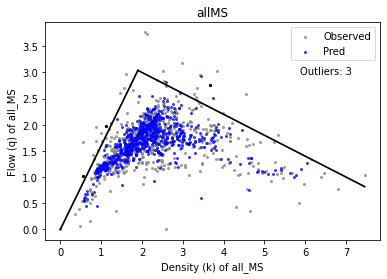

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.19488993 3.51664038]
Loss MAPE
 [0.5612685832549261, 0.37477461995045613]
Loss RMSE
 [2.20559191 4.89976731]
Loss R2
 [0.6667688483645406, 0.6285831235905502]
##################################################################
18 Scen10_qk 0.6
##################################################################


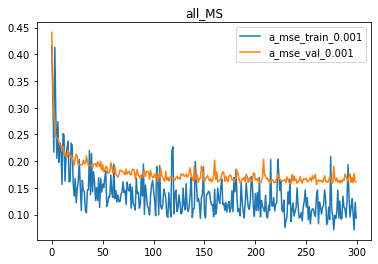

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [182.74641    15.8351965]
Loss MAPE
 [0.15634632, 0.1900756]
Loss RMSE
 [350.81705   28.924055]
Loss R2
 [0.8486081539910709, 0.753902672773046]
Loss MAE
 [182.74637, 15.835188]
Loss MAPE
 [368585000000000.0, 0.1900756]
Loss RMSE
 [350.8169594852849, 28.924064400855627]
Loss R2
 [0.8392124502659961, 0.7488879846915271]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


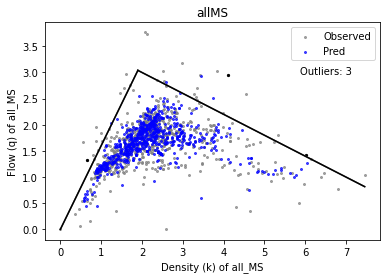

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.36104695 3.80524306]
Loss MAPE
 [0.5584616168842238, 0.4307899250665941]
Loss RMSE
 [2.63445478 5.29885266]
Loss R2
 [0.5253515123777294, 0.5483830332018041]
##################################################################
18 Scen11_qk 0.6
##################################################################


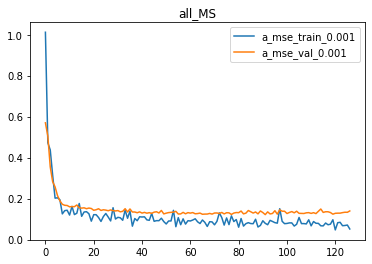

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [148.32758   11.310099]
Loss MAPE
 [0.12825559, 0.12832896]
Loss RMSE
 [255.47748  18.26399]
Loss R2
 [0.9121114004887372, 0.8943309604794246]
Loss MAE
 [148.32755, 11.310101]
Loss MAPE
 [1.5406141e+16, 372640820000000.0]
Loss RMSE
 [255.4774558914152, 18.263989247222423]
Loss R2
 [0.9119742052752801, 0.8943064133313164]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


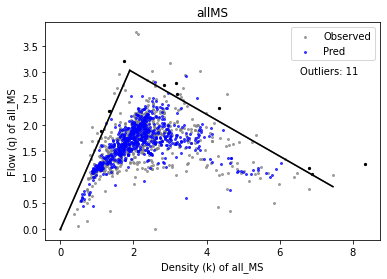

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.11682932 4.02207879]
Loss MAPE
 [0.44870004508148387, 0.4805610755547079]
Loss RMSE
 [1.81021447 5.48574681]
Loss R2
 [0.7645617335115343, 0.5976374372801324]
##################################################################
19 Scen0_qk 0.6
##################################################################


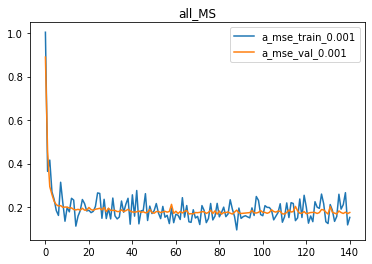

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [180.28062   15.406639]
Loss MAPE
 [0.1560242, 0.17745036]
Loss RMSE
 [351.52258  25.71381]
Loss R2
 [0.8557494039765983, 0.791388691814855]
Loss MAE
 [180.28065, 15.406647]
Loss MAPE
 [0.1560242, 0.17745036]
Loss RMSE
 [351.52260329173714, 25.713810943580253]
Loss R2
 [0.8391833749355662, 0.7870560095502592]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


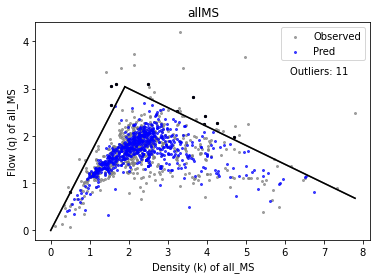

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.27314371 3.82483705]
Loss MAPE
 [0.6516229703106643, 0.39886217821666703]
Loss RMSE
 [2.37200901 5.34647047]
Loss R2
 [0.5972903328096683, 0.6071934393098621]
##################################################################
19 Scen1_qk 0.6
##################################################################


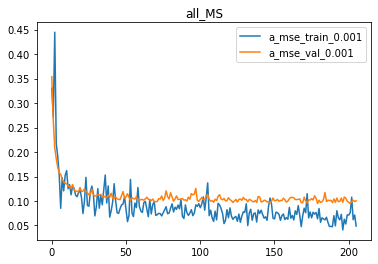

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [147.36305   10.999675]
Loss MAPE
 [0.093473405, 0.11642267]
Loss RMSE
 [255.75046   18.009224]
Loss R2
 [0.917186614756918, 0.9063205013899895]
Loss MAE
 [147.36314, 10.999672]
Loss MAPE
 [7018286300000000.0, 302512330000000.0]
Loss RMSE
 [255.75050403176138, 18.00922327038938]
Loss R2
 [0.9144400998198537, 0.9043541566569191]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


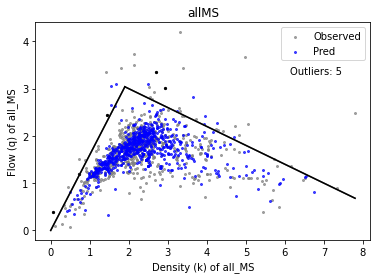

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [2.75542419 4.75827561]
Loss MAPE
 [0.5446107133520436, 0.5499835970715716]
Loss RMSE
 [3.56797699 6.53583322]
Loss R2
 [0.29441909036430036, 0.4247403083215616]
##################################################################
19 Scen3_qk 0.6
##################################################################


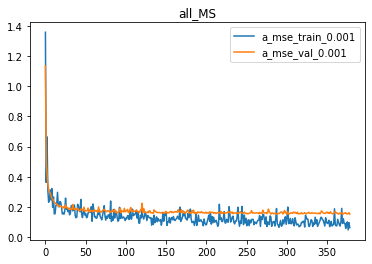

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [156.12276   13.749639]
Loss MAPE
 [0.13038197, 0.15129997]
Loss RMSE
 [313.65744   24.404379]
Loss R2
 [0.8737270501727218, 0.8062688239448247]
Loss MAE
 [156.12286, 13.749648]
Loss MAPE
 [1.1534182e+16, 406054760000000.0]
Loss RMSE
 [313.65741910960753, 24.40437932971765]
Loss R2
 [0.8704598617709531, 0.8019004017076671]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


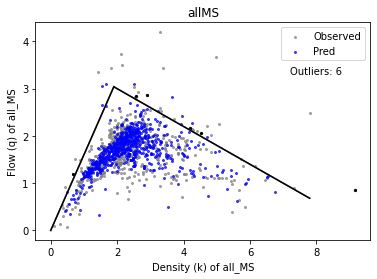

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.09926423 3.93587614]
Loss MAPE
 [0.5477109351044663, 0.41391938752572416]
Loss RMSE
 [1.99358152 5.22799344]
Loss R2
 [0.6171336697416658, 0.6022506802497094]
##################################################################
19 Scen10_qk 0.6
##################################################################


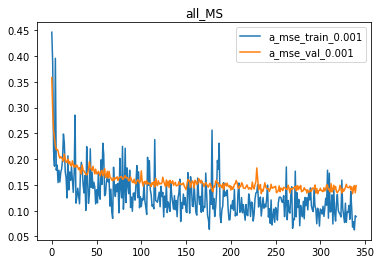

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [194.96042   15.048968]
Loss MAPE
 [0.13365792, 0.15252207]
Loss RMSE
 [343.9138    27.243853]
Loss R2
 [0.8551221989000374, 0.7903671285433912]
Loss MAE
 [194.96046, 15.048976]
Loss MAPE
 [1.6353761e+16, 561681930000000.0]
Loss RMSE
 [343.9138927478796, 27.243850994163573]
Loss R2
 [0.8452834801340443, 0.7811164618555058]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


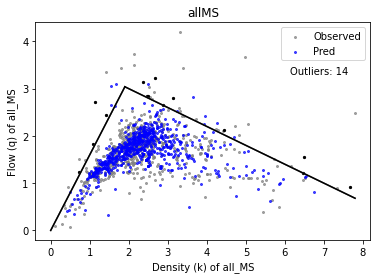

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.34619276 3.80081075]
Loss MAPE
 [0.5691119034730278, 0.38554288076976734]
Loss RMSE
 [2.37603235 5.48547739]
Loss R2
 [0.6068243409408192, 0.5727568370443005]
##################################################################
19 Scen11_qk 0.6
##################################################################


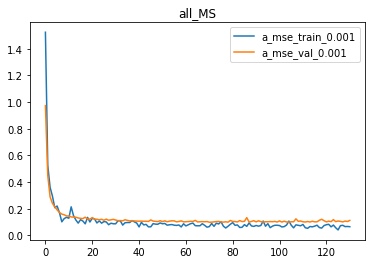

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [145.1686    12.826291]
Loss MAPE
 [0.119251944, 0.14453264]
Loss RMSE
 [268.00537   20.779629]
Loss R2
 [0.9077145149966268, 0.871411206528439]
Loss MAE
 [145.1685, 12.826289]
Loss MAPE
 [9118744000000000.0, 258003050000000.0]
Loss RMSE
 [268.0054074780955, 20.779631633412382]
Loss R2
 [0.9054241311006435, 0.856377066076591]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:180: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21088\127726727.py:209: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]


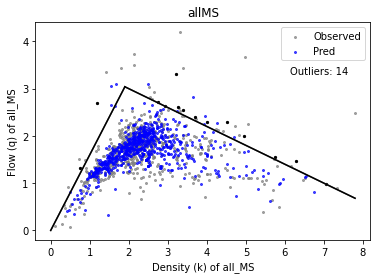

##################################################################
First Stage done, second starting
##################################################################
Output_sensor_cols: ['stop_count', 'lane_changes']
Loss MAE
 [1.02477681 4.0513242 ]
Loss MAPE
 [0.4569346011864933, 0.4395418136848499]
Loss RMSE
 [1.77123507 5.70157624]
Loss R2
 [0.7809241126286625, 0.5824110689043517]


Scenario                   Method                            Params  \
0    Scen0_qk  NNFD_w_events_two_stage  [D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]   
12   Scen1_qk  NNFD_w_events_two_stage  [D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]   
24   Scen3_qk  NNFD_w_events_two_stage  [D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]   
36  Scen10_qk  NNFD_w_events_two_stage  [D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]   
48  Scen11_qk  NNFD_w_events_two_stage  [D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]   

      Pol  Run                                                MAE  \
0   total    0  [200.7135009765625, 14.598565101623535, 2.9576...   
12  total    0  [138.25404357910156, 12.675278663635254, 2.365...   
24  total    0  [206.5552215576172, 14.18803882598877, 2.67317...   
36  total    0  [173.61326599121094, 15.80774211883545, 2.9191...   
48  total    0  [144.91404724121094, 12.23946762084961, 2.8860...   

                                                 MAPE  \
0   [0.15315147, 0.16070168, 0.18758332718626883, ...   
12  [0.11721264, 0.15495186, 0.1513798702243625, 0...   
24  [0.11273856, 0.14027384, 0.1605391142138727, 0...   
36  [0.13626105, 0.18533354, 0.18030895088655716, ...   
48  [0.14521462, 0.1506525, 0.1554751416214722, 0....   

                                                 RMSE  \
0   [384.7896728515625, 24.090068817138672, 4.3386...   
12  [269.8347473144531, 23.03844451904297, 3.32618...   
24  [361.0838928222656, 23.25911521911621, 3.94823...   
36  [317.4335021972656, 28.885482788085938, 4.0556...   
48  [274.031982421875, 18.466707229614258, 16.1341...   

                                                   R2  \
0   [0.8210778664790787, 0.8161618314964938, 0.849...   
12  [0.9075324763148781, 0.8544855566185886, 0.913...   
24  [0.8322018189232262, 0.8402697717820181, 0.874...   
36  [0.8723821578700729, 0.7915320228933567, 0.875...   
48  [0.9042130029870925, 0.9107176405884693, 0.302...   

                                                MAE_n  \
0   [200.71341, 14.598557, 2.9576346662796635, 2.7...   
12  [138.25414, 12.675276, 2.365563868973027, 1.90...   
24  [206.5552, 14.188022, 2.6731759200009475, 2.49...   
36  [173.61322, 15.807754, 2.9191895808432764, 2.4...   
48  [144.91405, 12.239464, 2.886043478738429, 2.82...   

                                               MAPE_n  \
0   [1.8814935e+16, 428400700000000.0, 55142503056...   
12  [90853465000000.0, 30105322000000.0, 0.1511043...   
24  [3.7873382e+16, 1135105000000000.0, 3646196510...   
36  [3318362000000000.0, 100508620000000.0, 0.1808...   
48  [0.14521462, 0.1506525, 0.15540621648820388, 0...   

                                                 R2_n  Outliers  \
0   [0.800312080803381, 0.8161205060918857, 0.8473...         9   
12  [0.9068383371785336, 0.854429546327161, 0.9038...        10   
24  [0.8248656780149585, 0.8392784991138387, 0.867...         3   
36  [0.8710720608096287, 0.7711629796524635, 0.857...        10   
48  [0.9022702357286358, 0.8901723880873602, -1.16...        18   

                                                 Cols  
0   [q_all_MS, k_all_MS, v_all_MS_Target, v_all_MS...  
12  [q_all_MS, k_all_MS, v_all_MS_Target, v_all_MS...  
24  [q_all_MS, k_all_MS, v_all_MS_Target, v_all_MS...  
36  [q_all_MS, k_all_MS, v_all_MS_Target, v_all_MS...  
48  [q_all_MS, k_all_MS, v_all_MS_Target, v_all_MS...

In [5]:
##############
# NN Params - torch - q&k as multi-output to get FD diagram
##############

# save polygon information
polygoncol = pd.DataFrame(data['polygon'])
polygoncol['idcs'] = polygoncol.index
fixed_cols = ['lanes','busstops','seplane','length','road_rank']
method = 'NNFD_w_events_two_stage'

save_results = 'on'
numruns = 20 # 20
calcV = 'yes'

save_all = []
numoutside = []
runs = []
save_sec_stage = []
for run in range(numruns):
    for ii,ff in enumerate([0.6]): #[0,0.3,0.6]
        ff = round(ff,2)
        saveall = []
        allpreds = []
        alltrues = []

        for sensor_scenario in ['Scen%s_qk'%i for i in [0,1,3,10,11]]:#[1,2,3,4,5,6,7,8,9,10]]:

            print('##################################################################')
            print(run,sensor_scenario,ff)
            print('##################################################################')
        
            input_sensor_cols,output_sensor_cols = sensor_scenarios[sensor_scenario]
            output_sensor_cols = ['q_all_MS','k_all_MS']
            data_norm = data

            ##############
            # 0. split data set
            ##############
            x = np.array(data_norm[fixed_cols+input_sensor_cols])
            y = np.array(data_norm[output_sensor_cols])
            s_train,s_test,s_val,randstate = [0.7,0.15,0.15,randrange(10)]
            x_train, x_test_, y_train, y_test_ = train_test_split(x, y, test_size=s_test, random_state=randstate)
            x_train_, x_val_, y_train_, y_val_ = train_test_split(x_train, y_train, test_size=s_val/(1-s_test), random_state=randstate) # 0.2143 = 0.15 / 0.7
            i_train, i_test, p_train, p_test = train_test_split(polygoncol['idcs'],polygoncol['polygon'],test_size=s_test,random_state=randstate)
            i_train, i_val, p_train, p_val = train_test_split(i_train, p_train,test_size=s_val/(1-s_test),random_state=randstate)

            targetk = output_sensor_cols[1]
            tk = output_sensor_cols.index(targetk)
            targetq = output_sensor_cols[0]
            tq = output_sensor_cols.index(targetq)
            target = targetk[2:]

            ##############
            # 1. Set-up
            ##############
            hparams = {
                "batch_size": 256,
                "learning_rate": 0.001,
                "input_size": len(fixed_cols+input_sensor_cols),
                "output_size": 2,
                "hidden_layers": 7,
                "neurons": 64,
                "inclKaiming": 1,
                "activation_function": torch.nn.LeakyReLU(),
                "gt0_loss_contraint": 0, # 0.01, if include loss for values <0 (q, k)
                "underFD_loss_contraint": ff,
                "max_epochs": 500,
                "FDparams":['D',1.9,1.9,1.6,-0.4,0],
                #"FDparams":['G',3.9,3.9,1.8,-2.1,0], 
                #"FDparams":['T',1.6,3.5,1.6,-0.5,0], 
                # Daganzo (D), Trapezoid (T), Greenshield (G)
                # FDType, mid, mid2, slopeL, slopeR, qdist
            }
            losses = []
            def loss_function(y_predicted, y_target):
                return ((y_predicted - y_target)**2).mean()

            ##############
            # 2. create DataLoader objects
            ##############
            train_dl = myDataLoader(x_train_,y_train_[:,[tq,tk]])
            val_dl = myDataLoader(x_val_,y_val_[:,[tq,tk]])
            test_dl = myDataLoader(x_test_,y_test_[:,[tq,tk]])   
            train_dl_batches = torch.utils.data.DataLoader(train_dl, batch_size=hparams['batch_size'], shuffle=True)
            
            ##############
            # 3. train model
            ##############
            device = torch.device("cpu")                       
            model = Net(hparams).to(device)
            optimizer = model.configure_optimizer()
            valbreak = 0
            for epoch in range(0, hparams['max_epochs']):
                epoch_loss = 0  # for one full epoch
                if valbreak == 0:
                    
                    for (batch_idx, batch) in enumerate(train_dl_batches):
                        (x_train, y_train) = batch              # (predictors, targets)
                        optimizer.zero_grad()                   # prepare gradients
                        out = model(x_train)                    # predicted
                        # additional loss if above FD curve
                        loss = loss_function_NNFD(y_train,out,hparams['underFD_loss_contraint'],hparams['FDparams']) #ax=0  
                        # additional loss if <0
                        if len(out[out<0])>0:
                            loss_constraint = abs(out[out<0]-y_train[out<0]).sum()
                            loss += loss_constraint*hparams['gt0_loss_contraint']
                        epoch_loss += loss.item()
                        loss.backward(retain_graph=True)        # compute gradients
                        optimizer.step()                        # update
                    
                    (x_val, y_val) = val_dl.getall()
                    with torch.no_grad():
                        loss_val = loss_function(model(x_val), y_val)
                    losses.append([epoch,loss.item(),loss_val.item()])
                    if len(losses)>100:
                        if np.mean(np.array(losses)[-50:,2])>np.mean(np.array(losses)[-100:-50,2]):
                            valbreak = 1
                                                             
            ##############
            # 4. evaluate model accuracy
            ##############
            plot_losses(losses[:],hparams['learning_rate'],target)
            #print('\nInput\n',input_sensor_cols)
            print('Output\n',target)
            # (predictors, targets)
            (x_test, y_test) = test_dl.getall() 
            with torch.no_grad():
                preds = model(x_test)
            # reformat 
            preds_q = preds.detach().numpy()[:,0]
            preds_k = preds.detach().numpy()[:,1]
            y_test_q = y_test.detach().numpy()[:,0]
            y_test_k = y_test.detach().numpy()[:,1]
            # save for tmp analysis
            allpreds.append(preds_q); allpreds.append(preds_k)
            alltrues.append(torch.tensor(y_test_q)), alltrues.append(torch.tensor(y_test_k))

            # saving the outliers by FDType
            ax=0
            FDType,mid,mid2,slopeL,slopeR,qdist = hparams['FDparams']
            ALIdcsO,AMIdcsO,ARIdcsO,PLIdcsO,PMIdcsO,PRIdcsO = [[],[],[],[],[],[]]
            if FDType=='D':
                ALIdcsO = list(np.where((y_test_k<mid) & (qdist+slopeL*y_test_k <= y_test_q))[ax])
                PLIdcsO = list(np.where((preds_k <mid) & (qdist+slopeL*preds_k  <= preds_q ))[ax])
                ARIdcsO = list(np.where((y_test_k>=mid) & ((qdist+slopeL*mid+(y_test_k-mid)*slopeR) <= y_test_q))[ax])
                PRIdcsO = list(np.where((preds_k >=mid) & ((qdist+slopeL*mid+(preds_k -mid)*slopeR) <= preds_q ))[ax])
            elif FDType=='T':
                ALIdcsO = list(np.where((y_test_k<mid) & (qdist+slopeL*y_test_k <= y_test_q))[ax])
                PLIdcsO = list(np.where((preds_k <mid) & (qdist+slopeL*preds_k  <= preds_q ))[ax])
                AMIdcsO = list(np.where((y_test_k>=mid) & (y_test_k<mid2) & ((qdist+slopeL*mid) <= y_test_q))[ax])
                PMIdcsO = list(np.where((preds_k >=mid) & (preds_k <mid2) & ((qdist+slopeL*mid) <= preds_q ))[ax])
                ARIdcsO = list(np.where((y_test_k>=mid2) & ((qdist+slopeL*mid+(y_test_k-mid2)*slopeR) <= y_test_q))[ax])
                PRIdcsO = list(np.where((preds_k >=mid2) & ((qdist+slopeL*mid+(preds_k -mid2)*slopeR) <= preds_q ))[ax])
            elif FDType=='G':
                vfree = slopeL
                kjam = mid - slopeL*mid/slopeR # x intercept of slope R
                ALIdcsO = list(np.where((qdist+vfree*y_test_k*(1-(y_test_k/kjam)) <= y_test_q))[ax])
                PLIdcsO = list(np.where((qdist+vfree*preds_k *(1-(preds_k /kjam)) <= preds_q ))[ax])
            else:
                print("Please set the FD type to 'D', 'T', or 'G'.")
            AIdcsO = ALIdcsO+AMIdcsO+ARIdcsO 
            PIdcsO = PLIdcsO+PMIdcsO+PRIdcsO 
            idcs = test_dl.getIdcs()
            idcs = np.array(i_test)[idcs]         
            origO_t = data.loc[ idcs[AIdcsO] ,:]
            origO_p = data.loc[ idcs[PIdcsO] ,:]
            print('FD factor:',hparams['underFD_loss_contraint'],'- Num. outside of FD:',len(PIdcsO))
            
            # overall error
            cols = [a for a in output_sensor_cols]
            p,t = [preds.detach().numpy(),y_test.detach().numpy()]
            p = scaleup(p,p_test,scalefactors,cols)
            t = scaleup(t,p_test,scalefactors,cols)
            avg_mae,avg_mape,avg_rmse,r2 = calc_error_values(p,t)
            avg_mae_n,avg_mape_n,avg_rmse_n,r2_n = calc_error_values_default(p,t,verbose='on') #default value for r2 from sklearn
            if calcV=='yes':
                vCols = ['v_%s'%a for a in set([c[2:] for c in output_sensor_cols])]
                vOrig = np.array(data.iloc[i_test][vCols].values) # 703 x 5
                qcols,kcols = [range(0,len(output_sensor_cols),2),range(1,len(output_sensor_cols),2)]
                vTarget = t[:,qcols]/t[:,kcols]
                vPred   = p[:,qcols]/p[:,kcols]
                vpo_mae,vpo_mape,vpo_rmse,vpo_r2 = calc_error_values(vPred,vOrig,verbose='off')
                vpt_mae,vpt_mape,vpt_rmse,vpt_r2 = calc_error_values(vPred,vTarget,verbose='off')
                vpo_mae_n,vpo_mape_n,vpo_rmse_n,vpo_r2_n = calc_error_values_default(vPred,vOrig,verbose='off')
                vpt_mae_n,vpt_mape_n,vpt_rmse_n,vpt_r2_n = calc_error_values_default(vPred,vTarget,verbose='off')
                avg_mae += vpo_mae + vpt_mae
                avg_mape+= vpo_mape + vpt_mape
                avg_rmse+= vpo_rmse + vpt_rmse
                r2      += vpo_r2 + vpt_r2
                avg_mae_n += vpo_mae_n + vpt_mae_n
                avg_mape_n += vpo_mape_n + vpt_mape_n
                avg_rmse_n += vpo_rmse_n + vpt_rmse_n
                r2_n      += vpo_r2_n + vpt_r2_n
                cols    += ['%s_Target'%i for i in vCols] + ['%s_Orig'%i for i in vCols]
            print('\nInput\n%s\nOutput\n%s'%(input_sensor_cols,output_sensor_cols))
            save_all.append([sensor_scenario,method,\
                             hparams['FDparams']+[hparams['underFD_loss_contraint']],\
                             'total',run,avg_mae,avg_mape,avg_rmse,r2,avg_mae_n,avg_mape_n,r2_n,len(PIdcsO),cols])
            numoutside.append([ff,sensor_scenario,len(PIdcsO),avg_rmse[1],avg_mae[1],avg_rmse[0],avg_mae[0]])
            runs.append([run,sensor_scenario,ff,len(PIdcsO)])
            
            # err for each polygon
            p_copy = p_test.reset_index(inplace=False,drop=True)
            for pol in set(polygoncol.polygon):
                mask = p_copy[p_copy==pol].index.values
                avg_mae,avg_mape,avg_rmse,r2 = calc_error_values(p[mask],t[mask],verbose='off')
                if calcV=='yes':
                    vOrig = np.array(data.iloc[i_test][vCols].values)[mask,:] # 703 x 5
                    vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]
                    vPred   = p[:,qcols][mask,:]/p[:,kcols][mask,:]
                    vpo_mae,vpo_mape,vpo_rmse,vpo_r2 = calc_error_values(vPred,vOrig,verbose='off')
                    vpt_mae,vpt_mape,vpt_rmse,vpt_r2 = calc_error_values(vPred,vTarget,verbose='off')
                    avg_mae += vpo_mae + vpt_mae
                    avg_mape+= vpo_mape + vpt_mape
                    avg_rmse+= vpo_rmse + vpt_rmse
                    r2      += vpo_r2 + vpt_r2
                save_all.append([sensor_scenario,method,\
                             hparams['FDparams']+[hparams['underFD_loss_contraint']],\
                             pol,run,avg_mae,avg_mape,avg_rmse,r2,'-','-','-',len(PIdcsO),cols])

            # plot preds with FD curve
            plot_preds(alltrues,allpreds,avg_mae,avg_rmse,output_sensor_cols,hparams['FDparams'],ff,1,save='off')
            plt.scatter(preds_k[PIdcsO],preds_q[PIdcsO],color='black',s=5)
            plt.ylim(bottom=-0.2)
            plt.text(.75*plt.gca().get_xlim()[1], .75*plt.gca().get_ylim()[1], 'Outliers: %s'%(len(PIdcsO)),size=10)
            plt.title('allMS')
            #plt.savefig('%s_%s.pdf'%(run,ff), format='pdf', dpi=1200, bbox_inches='tight')
            plt.show()

            print('##################################################################')
            print('First Stage done, second starting')
            print('##################################################################')

            with torch.no_grad():
                preds_qk = model(torch.Tensor(x))
            qk_pred,qk_target_pred = [np.array(preds_qk),np.array(y)]
            data['q_pred'] = qk_pred[:,0]
            data['k_pred'] = qk_pred[:,1]
            qk_pred = scaleup(qk_pred,polygoncol['polygon'],scalefactors,cols[:2])
            qk_target_pred = scaleup(qk_target_pred,polygoncol['polygon'],scalefactors,cols[:2])
            v_pred = qk_pred[:,0]/qk_pred[:,1]
            data['v_pred'] = v_pred

            input_sensor_cols_sec = input_sensor_cols + ['q_pred','k_pred','v_pred']
            output_sensor_cols_sec = ['stop_count','lane_changes']
            ##############
            # 2.0. split data set
            ##############
            x_sec = np.array(data[fixed_cols+input_sensor_cols_sec])
            print('Output_sensor_cols: %s'%output_sensor_cols_sec)
            y_sec = np.array(data[output_sensor_cols_sec])
            s_train,s_test,s_val,randstate = [0.7,0.15,0.15,randrange(10)] 
            x_train, x_test, y_train, y_test = train_test_split(x_sec, y_sec, test_size=s_test, random_state=randstate)
            x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=s_val/(1-s_test), random_state=randstate)
            i_train, i_test, p_train, p_test = train_test_split(polygoncol['idcs'],polygoncol['polygon'],test_size=s_test,random_state=randstate)
            i_train, i_val, p_train, p_val = train_test_split(i_train, p_train,test_size=s_val/(1-s_test),random_state=randstate)

            ##############
            # 2.1. Set-up
            ##############
            hparams = {
                "batch_size": 256,
                "learning_rate": 0.001, #0,001
                "input_size": len(fixed_cols+input_sensor_cols_sec),
                "output_size": len(output_sensor_cols_sec),
                "hidden_layers": 7, #7
                "neurons": 64,
                "inclKaiming": 1,
                "activation_function": torch.nn.LeakyReLU(),
                "gt0_loss_contraint": 0.01,
                "max_epochs": 1000, #500
            }
            ep_log_interval = 50
            loss_func = torch.nn.MSELoss(reduction='mean')

            ##############
            # 2.2. create DataLoader objects
            ##############
            train_dl_sec = myDataLoader(x_train,y_train)
            val_dl_sec = myDataLoader(x_val,y_val)
            test_dl_sec = myDataLoader(x_test,y_test)
            train_dl_batches_sec = torch.utils.data.DataLoader(train_dl_sec, batch_size=hparams['batch_size'], shuffle=True)

            ##############
            # 2.3. train model
            ##############
            device = torch.device("cpu") 
            net_sec = Net(hparams).to(device)
            optimizer_sec = net_sec.configure_optimizer()
            losses_sec = []
            valbreak = 0
            for epoch in range(0, hparams['max_epochs']):
                epoch_loss = 0  # for one full epoch
                if valbreak == 0:
                    for (batch_idx, batch) in enumerate(train_dl_batches_sec):
                        (x_train, y_train) = batch            # (predictors, targets)
                        optimizer_sec.zero_grad()                 # prepare gradients
                        out = net_sec(x_train)                    # predicted
                        loss = loss_func(out, y_train)        # avg per item in batch
                        # additional loss if <0
                        if len(out[out<0])>0:
                            loss_constraint = abs(out[out<0]-y_train[out<0]).sum()
                            loss += loss_constraint*hparams['gt0_loss_contraint']
                        epoch_loss += loss.item()             # accumulate avgs
                        loss.backward()                       # compute gradients
                        optimizer_sec.step()                      # update
                    _,loss_val = accuracy(net_sec,val_dl_sec)
                    losses_sec.append([epoch,loss.item(),loss_val.item()])
                    if (len(losses_sec)>100):
                        #if (np.mean(np.array(losses_sec)[-25:,2])>np.mean(np.array(losses_sec)[-50:-25,2])):
                        if (np.mean(np.array(losses_sec)[-50:,2])>np.mean(np.array(losses_sec)[-100:-50,2])):
                            valbreak = 1
            cols_sec = [a for a in output_sensor_cols_sec]
            with torch.no_grad():
                preds = net_sec(torch.Tensor(x_test))
            y_p,t_p = [np.array(preds),np.array(y_test)]
            avg_mae,avg_mape,avg_rmse,r2 = calc_error_values(y_p,t_p)
            avg_mae_n,avg_mape_n,avg_rmse_n,r2_n = calc_error_values_default(y_p,t_p)
            save_sec_stage.append([sensor_scenario,method,'-','total',run,avg_mae,avg_mape,avg_rmse,r2,avg_mae_n,avg_mape_n,r2_n,0,cols_sec])

#save_all: first stage, save_sec_stage: second stage
results = pd.DataFrame(save_all,columns=['Scenario','Method','Params','Pol','Run','MAE','MAPE','RMSE','R2','MAE_n','MAPE_n','R2_n','Outliers','Cols'])
results_sec = pd.DataFrame(save_sec_stage,columns=['Scenario','Method','Params','Pol','Run','MAE','MAPE','RMSE','R2','MAE_n','MAPE_n','R2_n','Outliers','Cols'])
display(results[results.Pol=='total'].head())
if save_results == 'on':
    results.to_pickle('../output/result_runs_w_events/%s_%s_runs_first_stage_qkvtv.pkl'%(method,numruns))
    results_sec.to_pickle('../output/result_runs_w_events/%s_%s_runs_second_stage_sl.pkl'%(method,numruns))


In [52]:
def calc_mean_qk(g1):
    q_m,k_m,v_t_m, v_m = [0,0,0,0]
    for i in g1:
        q_m += i[0]
        k_m += i[1]
        v_t_m += i[2]
        v_m += i[3]
    dev = len(g1)    
    return ["{:.3f}".format(q_m/dev),
            "{:.3f}".format(k_m/dev),
            "{:.3f}".format(v_t_m/dev),
            "{:.3f}".format(v_m/dev)]
only_total = results[results.Pol=='total']
mean_mape_s = only_total.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_qk(x))
mean_r2_s = only_total.groupby('Scenario')['R2'].apply(lambda x: calc_mean_qk(x))
#mean_r2_n_s = only_total.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean(x))
print('MAPE second stage: %s,\nR2 second stage: %s'%(mean_mape_s,mean_r2_s))

MAPE second stage: Scenario
Scen1_qk    [0.110, 0.144, 0.160, 0.138]
Name: MAPE, dtype: object,
R2 second stage: Scenario
Scen1_qk    [0.916, 0.902, 0.758, 0.777]
Name: R2, dtype: object


In [56]:
results_sec.Pol = ['total']*len(results_sec)

In [12]:
def calc_mean_sl(g1):
    s_m,l_m = [0,0]
    for i in g1:
        s_m += i[0]
        l_m += i[1]
    dev = len(g1)    
    return ["{:.3f}".format(s_m/dev),
            "{:.3f}".format(l_m/dev)]
mean_mape_s = only_total.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_sl(x))
mean_r2_s = only_total.groupby('Scenario')['R2'].apply(lambda x: calc_mean_sl(x))
mean_r2_n_s = only_total.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_sl(x))
print('MAPE second stage: %s, \nR2 second stage: %s. \nR2 default second stage: %s'%(mean_mape_s,mean_r2_s,mean_r2_n_s))

MAPE second stage: Scenario
Scen1_qk    [0.454, 0.328]
Name: MAPE, dtype: object, 
R2 second stage: Scenario
Scen1_qk    [0.764, 0.706]
Name: R2, dtype: object. 
R2 default second stage: Scenario
Scen1_qk    [0.749, 0.696]
Name: R2_n, dtype: object


In [16]:
#print loss of the whole dataset:
with torch.no_grad():
    preds = model(torch.Tensor(x))
y_p,t_p = [np.array(preds),np.array(y)]
y_p = scaleup(y_p,polygoncol['polygon'],scalefactors,cols[:2])
t_p = scaleup(t_p,polygoncol['polygon'],scalefactors,cols[:2])
for i in range(0,2):
    print('R2: %s'%r2_score(t_p[:,i],y_p[:,i]))
    print('MAPE: %s'%mean_absolute_percentage_error(t_p[:,i],y_p[:,i]))
    print('MAE: %s'%mean_absolute_error(t_p[:,i],y_p[:,i]))
    print('RMSE: %s'%mean_squared_error(t_p[:,i],y_p[:,i])**0.5)

R2: 0.8996728682204203
MAPE: 4705355785003315.0
MAE: 177.86203014517707
RMSE: 276.49714530888576
R2: 0.8968515988480413
MAPE: 180330366750952.28
MAE: 12.125185346838643
RMSE: 18.684721477325745


In [60]:
#print loss of the whole dataset:
with torch.no_grad():
    preds = net_sec(torch.Tensor(np.array(pd.DataFrame(x_sec).iloc[i_test])))
y_p,t_p = [np.array(preds),np.array(pd.DataFrame(y_sec).iloc[i_test])]
for i in range(0,2):
    print('R2: %s'%r2_score(t_p[:,i],y_p[:,i]))
    print('MAPE: %s'%mean_absolute_percentage_error(t_p[:,i],y_p[:,i]))
    print('MAE: %s'%mean_absolute_error(t_p[:,i],y_p[:,i]))
    print('RMSE: %s'%mean_squared_error(t_p[:,i],y_p[:,i])**0.5)

R2: 0.713305604394677
MAPE: 1099139667602744.5
MAE: 1.0164651017889124
RMSE: 1.8757027653872458
R2: 0.5553754651390559
MAPE: 210351835790473.62
MAE: 3.8467539067027237
RMSE: 5.495562611377103


In [7]:
[0]*4

[0, 0, 0, 0]